---

***status:***
   
    
    
---


to do: reduce noise and get pramater right for tvb model to not bee ridcilously bad


*maybe need to starti using decm for parameter estimation


- i've got a '2-point' neural field model for tvb

...not entirely sure if it is working propoerly though . need to explore paramneter space. 

the flat edge on the power spectrum seems to be able to be generated from even uncoupled neural fields. 



Q: will the tvb sims look like the 1D sims re: the tailing off at lower frequencies if plotted on the same scale...

In [1]:
# So we can get the same low-frequency power 'flatline' 
# from a TVB regional sim. 

# I think the spectral peak is a red herring here. 

# Question now is, can we get the non-flat line bit from 
# a TVB surface sim...

fig, ax = plt.subplots()

df_tp.plot(logx=True,logy=True,
        ylim=[10E-8,10E-1],xlim=[10E-1,10E2],linewidth=1.,ax=ax)

df_mts.mean(axis=1).plot(logx=True,logy=True,
        ylim=[10E-8,10E-1],xlim=[10E-1,10E2],linewidth=1.,legend=False,ax=ax,c='cyan')


NameError: name 'plt' is not defined

# TVB Neural Fields and Power Spectra

## Overview

Ever since their inception in the late 1950s, neural mass and neural field models have been used to study oscillations and power spectra, from a wide array of experimental preparations. including LFPs, EEG, MEG, ECoG, fMRI in humans, monkeys, rabbits, mice, in-vivo, ex-vivo; you name it. 

Here I want to take a closer look at the human M/EEG power spectrum. 

The two principal properties of the power spectrum are 

1. the presence of spectral peaks (primarily in the alpha range; but also to a lesser extent in  beta, theta, delta, and gamma frequencies also;

2. 1/f profile 

Very broadly, the spectral peaks are generally considered (at least in the modelling literature) to be due to local and/or global resonance effects in the dynamics of neural population activity. 



There are a variety of more specific theories and proposals on the details of these; I don't want to go into that too much here. 

Rather, here I want to take a look at the 1/f properties of the power spectra. 

A theoretical account of this was offered in Jirsa 2009. The idea discussed there is that the 1/f pattern is due to the spatiotemporal 'filtering' effects of local neural fields.


The following notes explore this idea theoretically and with numerical simulations. In particular, we want to go beyond the toy-ish 1D simulations in Jirsa 2009, study these effects in whole-brain surface-based simulations with TVB. 

## Notebook Setup

Define some variables

In [4]:
outdir = '/tmp/tvb_neural_fields_and_power_spectra'
!mkdir -p $outdir

tvb_folder = '../../../../../Code/libraries_of_others/github'
import os,sys,glob,numpy as np,pandas as pd
from copy import deepcopy

from scipy.signal import periodogram
from scipy import fft
from numpy import r_ ,conj
import powerlaw


%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import rc
from matplotlib.font_manager import FontProperties
import seaborn as sns
from IPython.display import Image

import moviepy
from moviepy.video.io.bindings import mplfig_to_npimage
import moviepy.editor as mpy
from IPython.display import clear_output

sys.path += [tvb_folder + '/' + t for t in ['tvb-library', 'tvb-data']]
from tvb.simulator.lab import *

In [6]:
if not os.path.isdir(outdir):
    os.makedirs(outdir)
os.chdir(outdir)

NF2pnt1D_outfile = outdir + '/NF2pnt1D_sims.h5'
tvbsims_outfile = outdir + '/TVB_sims.h5'

Define some functions

In [7]:
def compute_nitime_ps(dat,roi_names,sampling_interval):
    
  # note - time unit is seconds
  # dat is a rectangular matrix; rois x time
  T = TimeSeries(dat, sampling_interval=sampling_interval)
  T.metadata['roi'] = roi_names
  S = SpectralAnalyzer(T)

  df_fs = pd.DataFrame(np.abs(S.spectrum_fourier[1]),
                     columns=S.spectrum_fourier[0]).T
  df_fs.columns.names = ['roi']
  df_fs.index.names = ['freq']    

  df_mts = pd.DataFrame(np.abs(S.spectrum_multi_taper[1]),
                     columns=S.spectrum_multi_taper[0]).T
  df_mts.columns.names = ['roi']
  df_mts.index.names = ['freq']    
    

  return df_fs,df_mts,S


def run_tvb_sim(params,
            sim_len = 2e3,dt = 0.1,
            tau = 2,lca=0.01,
            tavg_per = 1.0,
            solver_type='det',
            nsig=1.,
            sim_type='region',
            local_coupling_strength=np.array([2 ** -10]),
            local_cutoff=40.0,
            local_eqn_params={'amp': 1.0, 'midpoint': 0.0, 
                              'offset': 0.0, 'sigma': 1.0},
            conn=None,
            surf=None):
    
  if conn is None:
    conn = connectivity.Connectivity(load_default=True)
        
  model = models.Generic2dOscillator(**params)
  cpl=coupling.Linear(a=lca)
  mons=(monitors.TemporalAverage(period=tavg_per),)
    
  if solver_type == 'det': 
    solver=integrators.HeunDeterministic(dt=dt)
  elif solver_type == 'stoch':
    solver=integrators.HeunStochastic(dt=dt,noise=noise.Additive(nsig=nsig))

  if sim_type=='region': 
    surf=None
  elif sim_type=='surface':
    if surf is None:        
      surf = Cortex(region_mapping_data=RegionMapping.from_file('regionMapping_16k_76.txt'),
                            load_default=True)
        
    surf.coupling_strength = local_coupling_strength  
    surf.local_connectivity.cutoff = local_cutoff
    surf.local_connectivity.equation.parameters = local_eqn_params
    surf.configure()
    
  sim = simulator.Simulator(model = model,connectivity=conn,coupling=cpl,
                            integrator=solver, 
                            monitors=mons,
                            surface=surf)
  sim.configure()

  (tavg_time, tavg_data),  = sim.run(simulation_length=sim_len) 
    
  df_tavg = pd.DataFrame(np.squeeze(tavg_data),index=tavg_time)
  df_tavg.index.names = ['t']
  df_tavg.columns.names= ['node']
    
  if sim_type=='region': df_tavg.columns = conn.region_labels    
    
  return df_tavg

# from powerlaw package notebook example
def plot_basics(data, data_inst, fig, units):
    from powerlaw import plot_pdf, Fit, pdf
    annotate_coord = (-.4, .95)
    ax1 = fig.add_subplot(n_graphs,n_data,data_inst)
    x, y = pdf(data, linear_bins=True)
    ind = y>0
    y = y[ind]
    x = x[:-1]
    x = x[ind]
    ax1.scatter(x, y, color='r', s=.5)
    plot_pdf(data[data>0], ax=ax1, color='b', linewidth=2)
    from pylab import setp
    setp( ax1.get_xticklabels(), visible=False)

    if data_inst==1:
        ax1.annotate("A", annotate_coord, xycoords="axes fraction", fontproperties=panel_label_font)

    
    from mpl_toolkits.axes_grid.inset_locator import inset_axes
    ax1in = inset_axes(ax1, width = "30%", height = "30%", loc=3)
    ax1in.hist(data, normed=True, color='b')
    ax1in.set_xticks([])
    ax1in.set_yticks([])

    
    ax2 = fig.add_subplot(n_graphs,n_data,n_data+data_inst, sharex=ax1)
    plot_pdf(data, ax=ax2, color='b', linewidth=2)
    fit = Fit(data, xmin=1, discrete=True)
    fit.power_law.plot_pdf(ax=ax2, linestyle=':', color='g')
    p = fit.power_law.pdf()

    ax2.set_xlim(ax1.get_xlim())
    
    fit = Fit(data, discrete=True)
    fit.power_law.plot_pdf(ax=ax2, linestyle='--', color='g')
    from pylab import setp
    setp( ax2.get_xticklabels(), visible=False)

    if data_inst==1:
       ax2.annotate("B", annotate_coord, xycoords="axes fraction", fontproperties=panel_label_font)        
       ax2.set_ylabel(u"p(X)")# (10^n)")
        
    ax3 = fig.add_subplot(n_graphs,n_data,n_data*2+data_inst)#, sharex=ax1)#, sharey=ax2)
    fit.power_law.plot_pdf(ax=ax3, linestyle='--', color='g')
    fit.exponential.plot_pdf(ax=ax3, linestyle='--', color='r')
    fit.plot_pdf(ax=ax3, color='b', linewidth=2)
    
    ax3.set_ylim(ax2.get_ylim())
    ax3.set_xlim(ax1.get_xlim())
    
    if data_inst==1:
        ax3.annotate("C", annotate_coord, xycoords="axes fraction", fontproperties=panel_label_font)

    ax3.set_xlabel(units)
    

In [8]:
    

pylab.rcParams['xtick.major.pad']='8'
pylab.rcParams['ytick.major.pad']='8'
#pylab.rcParams['font.sans-serif']='Arial'

rc('font', family='sans-serif')
rc('font', size=10.0)
rc('text', usetex=False)



panel_label_font = FontProperties().copy()
panel_label_font.set_weight("bold")
panel_label_font.set_size(12.0)
panel_label_font.set_family("sans-serif")

Ok, let's get cracking. 

## Theory

*(in progress...)*

In [25]:
tvbsims_outfile + '/data/tvb_neural_fields_and_power_spectra'

'/tmp/tvb_neural_fields_and_power_spectra/TVB_sims.h5/data/tvb_neural_fields_and_power_spectra'

The main focus of these notes is fig 4. from Jirsa 2009:

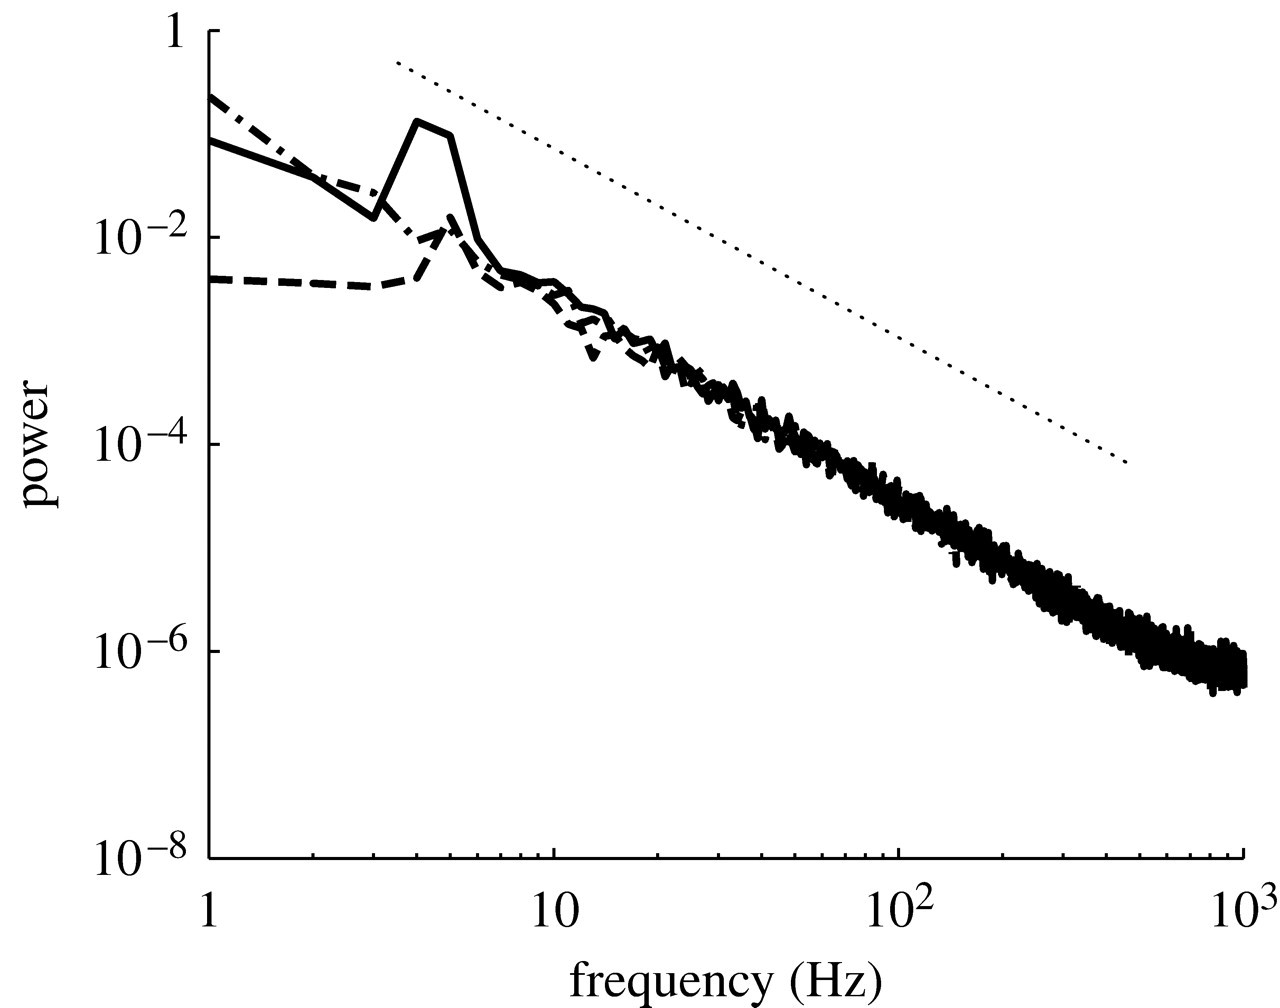

In [30]:
Image('data/tvb_neural_fields_and_power_spectra/Jirsa2009_fig4.jpg')

"""The figure caption in the paper reads as follows: 
"Figure 4. Power spectra of neural ﬁeld dynamics. Neural ﬁeld dynamics with 
purely homogeneous(dashed-dotted line), purely heterogeneous (dashed line) 
and both homogeneous and heterogeneous(full line), i.e. mixed, connections 
have been numerically integrated in the presence of white noise. A spectral 
peak occurs for purely heterogeneous and mixed connectivity. A 1/f^2 behaviour 
of the spectra is seen for purely homogeneous and mixed connectivity. Here, we 
show the results of simulations with u12=u21, where the spectral peak is most 
prevalent. The dotted line shows a slope of 2."
"""


Which is obtained from numerically integrating eq 2.12 from the paper:

\begin{array}
\dot{\Psi}(x,t) &= - \epsilon \psi(x,t) + D \frac{\partial^2}{\partial x^2} \psi(x,t) + \int_{\Gamma} W_{het} (x,y) S [\psi(y, t- | x-y|/v)] d y 
\end{array}

where $\Psi(x,t)$ denotes the neural population activity (firing rate) at location $x$ and time $t$, $W_{het}$ denotes a heterogeneous connectivity kernel, 

The spatial domain here ($x$) is 1-dimensional. Specified in this case on  on a 1-dimensional spatial manifold $x$a 1-dimensional 



The key points are described in the following passages from the paper:

>*"We illustrate these effects in a simulation of equation (2.12) with white noise. The  parameters are chosen such that the equilibrium state of the neural field is stable, but close to instability. As a consequence, the fluctuations continually kick the system out of its equilibrium, which then exhibits a characteristic transient dynamics back to equilibrium. The global field power, i.e.,the spatial integral over the power spectra of the neural field, is plotted in figure 4 for various configurations of connectivity. In all cases there is a 1/f^2 behaviour ofthe spectra for higher frequencies. However, the neural fields with homogeneous connectivity show enhanced power in the low-frequency regions, which is not thecase for the purely heterogeneously connected network. The discrete spectral peak in figure 4 is a consequence of the interactions between the two heterogeneously coupled regions"*

## Toy examples

(c.f. Jirsa 2009 etc.)

### 1D neural fields

We want to (stochastically) numerically integrate eqn. 2.12 in Jirsa et al. 2009

\begin{array}
\dot{\Psi}(x,t) &= - \epsilon \psi(x,t) + D \frac{\partial^2}{\partial x^2} \psi(x,t) + \int_{\Gamma} W_{het} (x,y) S [\psi(y, t- | x-y|/v)] d y  ,
\end{array}

(in the following, swap in $\Psi$ for $u$ and $D$ for $v$ to get correspondences with the Jirsa paper notation)

Starting with the diffusion term left of the integral:

For a 1D diffusion equation of the form 

$\frac{\partial u}{\partial t}= \nu \frac{\partial^2 u}{\partial x^2}$

one can use a simple central difference update scheme (see [here](http://nbviewer.jupyter.org/github/barbagroup/CFDPython/blob/master/lessons/04_Step_3.ipynb)
for derivation )

$\frac{\partial ^2 u}{\partial x^2}=\frac{u_{i+1}-2u_{i}+u_{i-1}}{\Delta x^2} + O(\Delta x^2)$, 

which gives the following expression for the discretized evolution of the system

$u_{i}^{n+1}=u_{i}^{n}+\frac{\nu\Delta t}{\Delta x^2}(u_{i+1}^{n}-2u_{i}^{n}+u_{i-1}^{n})$



Now for the heterogeneous coupling term: eqn. 3.1 in Jirsa et al. states how the above equation reduces to two coupled oscillations when $D=0$:

$\dot{x_i}(t) = - \epsilon x_i(t) + u_{ij} x_j (t- \tau) $

Discretize this and adjust the notation (as we're already using $x$ to denote space and $u$ to denote state; so we'll swap in $u$ and $c$ for $x$ and $u$, respectively ):

$u_i^{n+1}= - \epsilon u_i^n + c_{ij} u_j^{n-\tau} $

This term links two points $a$ and $b$ on our line $x$, with a non-local connection, with a coupling strength specified by entries of the matrix $c$. All entries of $c$ are zero apart from $c_{ab}$ and $c_{ba}$. 

We add a noise term $\sigma \sqrt{\Delta t} E_i$, where $E_i$ is a randomly chosen number between 0 and 1.


Ok now combine the homogeneous, heterogeneous, and noise terms:

$u_{i}^{n+1}=u_{i}^{n}+\frac{\nu\Delta t}{\Delta x^2}(u_{i+1}^{n}-2u_{i}^{n}+u_{i-1}^{n})  - \Delta t \epsilon u_i^n + \Delta t c_{ij} u_j^{n-\tau} + \sigma \sqrt{\Delta t} E_i $

Right, let's code this up:

---

In [31]:
#%load from_viktor/jg_NeuralfieldIntegrator.m

In [35]:
class NF2pnt1D(object):
  """
  ====================================================
  2-point 1D Neural Field Equation Solver
  ====================================================
  
  This is a very simple implemenation of a Jirsa-style 
  '2-point' neural field in one spatial dimension, 
  based on eqns from Jirsa 2009.
  
  The dynamics consists of three terms:
  
  - Homogeneous local connectivity (diffusive)
  - Heterogeneous (two-point) non-local connectivity, with delays
  - White noise
  
  A coupling matrix specifies the heterogeneous 
  connectivity weight between all nodes on the line. 
  Normally we are just concerned with two points on the line, 
  a and b, whose location on the line and coupling strengths 
  can be set arbitrarily.
  
  
  """
    
    
    
    
  def __init__(self,
               dx = 0.1,
               dt = 0.025,
               L = 3.,
               T = 50,
               vel = 1,
               sigma1 = 0.1 ,
               A1 = 1,
               sigma2 = 1,#  % additional localization params
               A2 = 0,
               homog_conn = 'exponential',#  % / 'gaussian' 
               init_state = 'random', # 'periodic',# % / 'random' / 'uniform'  / 'gaussian' / 'block'
               init_past = 'random', #oscillatory',# % constant / random
               boundary_type = 'zero_flux', # periodic',# % / zero flux
               input_type='block',
               c12 = 5.,
               c21 = -5.):
  
    """
    Initialize the class 
    """
    
    # importage
    import numpy as np
    from scipy.signal import periodogram,welch

    
  
  
    # 1. Define space and time
  
  
    # space
    x=r_[0:L+dx:dx] #x=r_[0:L:dx] 
    y = r_[0:L+dx:dx]#y=r_[0:L:dx]
    x0=r_[-L/2.:(L/2.)+dx:dx]#x0=r_[-L/2:L/2:dx];
    IDIM = int(L/dx + 1);#		% number of grid points
    print('Number IDIM of spatial grid points is %g \n'%IDIM)

  
    # time
    t = r_[0:T+dt:dt] #t=r_[0:T:dt];
    ndim = int(T/dt + 1);#% number of time points
    print('Number ndim of time points is %g \n' %ndim)

    maxdelay=L/vel; #          % maximal delay possible
    print('Maximal time delay is %g \n'  %maxdelay)

    IMAX = int(round(maxdelay/dt)+1) #		    % max number of delay time points
    print('Max number IMAX of delay time points is %g \n' %IMAX)

    
    # 2. Define connectivity
  
    
    #% connectivity matrix
    [x,y] = np.meshgrid(x,y);

  
    #% homogeneous connectivity  
    
    if homog_conn == 'exponential':
          
      #% w = A1*exp(-abs(x-y)/sigma1);       % Homogeneous connectivity IDIM x IDIM
      w = A1*np.exp(-abs(x-y)/sigma1)/sigma1/2.;    #   % Homogeneous connectivity IDIM x IDIM
        
    elif homog_con == 'gaussian':
          
      w = gauss(A1,sigma1,x-y)-gauss(A2,sigma2,x-y); 
      

        
    # heterogeneous connectivity
    
    #w[6:7,IDIM-7:IDIM-6]=5;              % Heterogeneous component
    #w[IDIM-7:IDIM-6,6:7]=-5; 

    ## JG ADD + mode - long-range connectivity weights    
    w[5:7,IDIM-7:IDIM-5]=c12;           #   % Heterogeneous component
    w[IDIM-7:IDIM-5,5:7]=c21
  
    # space-time matrix distributing connecitvity and time delay
    wsize=w.shape# np.shape(w) # size(w);
    ww=np.zeros([IMAX,wsize[0],wsize[1]]);   #' % creation of space-time matrix distributing
    
    
    homog_dist = (1.+abs(x-y)) # JG_ADD
                  
    
    itau=np.round(1.+abs(x-y)/dt/vel).astype(int);       #                % connectivity and time delay itau
    for ix in r_[1:IDIM].astype(int):#r_[1:IDIM-1:1]:
      for iy in r_[1:IDIM].astype(int):
        ww[itau[ix,iy],ix,iy]=w[ix,iy];

        

    x=x[0,:].T
    y=y[0,:].T 
    #(1,:)';            % space vectors are now again IDIM x 1

  
    # 3. Initialize neural field values
  
    if init_state == 'periodic':
        
        u = -0.5*sin(4.*pi/L*x);
        
    elif init_state == 'random':
          
        u = 0.1+0.001*(np.random.randn(IDIM,1)-0.5 );	
        
    elif init_state == 'uniform':
          
        u = 0.00*np.ones_like(x)
        
    elif init_state == 'gaussian':
          
        u = 0.005*gauss(A2,sigma2,x0.T); # % localized Gauss distribution
      
    elif init_state == 'block':
          
        u = 0.9*block(x,L/2.-dx,2.*dx);   # % localized block distribution
      
    
    
    zz = np.zeros([IDIM,ndim]);
    k=-1; 
    #                     % this will become the final space-time plot of
    #                                            % the neural field u


                                               
    if init_past == 'oscillatory':
                                                 
        told=r_[0:maxdelay+dt:dt];
        told=np.cos(2.*np.pi*told);  #    % oscillatory past
      
    elif init_past == 'constant':
          
        told=np.ones([1,IMAX]);  #                            % constant past
    
    elif init_past == 'random':
          
        told=(np.random.rand(1,IMAX)-0.5);        #         % random past
  
  
    if boundary_type == 'periodic':
      
        u[0]=0.5*(u[0]+u[idim]);
        u[idim]=u[0] #;		% periodic boundary conditions (connectivity has to be defined for this)

    elif boundary_type == 'zero_flux':
      
       u[0]=u[1];
       u[IDIM-1]=u[IDIM-2] # ;		        % zero flux boundary conditions
    
    uold=u*told;    #                            % Setting of initial time delayed initial conditions  

    pold=np.ones(u.shape)*np.sum(uold,axis=0)*dx/L
    #% pp will be the spatial mean of the neural field
    #                                        % and pold its delayed initial conditions
                                            

    if input_type == 'gaussian':
    
        s = 0.01*gauss(A2,sigma2,x0);
        
    elif input_type == 'block':
    
        s = 0.*block(x.T,L/2.-dx,2.*dx);
  
    s = s[np.newaxis,:]        
            
    self.dx = dx 
    self.dt = dt
    self.L = L
    self.T =  T
    self.vel = vel
    self.sigma1 = sigma1
    self.A1 = A1
    self.sigma2 = sigma2
    self.A2 = A2
    self.homog_conn = homog_conn
    self.init_state = init_state
    self.init_past = init_past
    self.boundary_type = boundary_type
    self.input_type = input_type
    self.c12 = c12
    self.c21 = c21
            
                        
    self.u = u
    self.uold = uold
    self.pold = pold
    self.told = told
    self.s = s
    self.zz = zz
    self.w = w
    self.ww = ww
    self.x = x
    self.y = y
    self.IDIM = IDIM
    self.IMAX = IMAX
    self.ndim = ndim
    self.maxdelay = maxdelay  
    self.t = t       
    self.k = k
    
    self.homog_dist = homog_dist # homogeneous connectivity distance
            
  
  def run(self):
  
  
            

    dx = self.dx 
    dt = self.dt
    L = self.L
    T =  self.T
    vel = self.vel
    sigma1 = self.sigma1
    A1 = self.A1
    sigma2 = self.sigma2
    A2 = self.A2
    homog_conn = self.homog_conn
    init_state = self.init_state
    init_past = self.init_past
    boundary_type = self.boundary_type
    input_type = self.input_type
    c12 = self.c12
    c21 = self.c21
            
                        
    u = self.u
    uold = self.uold
    told = self.told
    pold = self.pold
    s = self.s
    zz = self.zz
    w = self.w
    ww = self.ww
    x = self.x
    y = self.y
    IDIM = self.IDIM
    IMAX = self.IMAX
    ndim = self.ndim
    maxdelay = self.maxdelay  
    t = self.t 
    k = self.k
            
    #%% 4. Integrate eqns

    
    
    out1 = np.zeros([IDIM,IDIM])
    
    for it in r_[0:T:dt]:
      for ix in r_[0:IDIM]: #r_[1:IDIM+1:1]:
        out1[ix,:]=np.sum(ww[:,:,ix]*np.arctan(uold).T,axis=0);
                       
      out2=np.sum(out1.T*dx,axis=0).T[:,np.newaxis]
      noise=5.*(np.random.rand(IDIM,1)-0.5);
            
      u = u + dt*( -u + out2 + noise + s.T*block(it,50*dt,100*dt)*np.sin(np.pi*(it-50*dt)/25./dt)); 
            
      #%        u = u + dt*( -u + 0.5*out2 + s'*block(it,10*dt,20*dt) );   
      #%  u(1)=0.5*(u(1)+u(IDIM));u(IDIM)=u(1);		        % periodic boundary conditions
      u[0]=u[1];
      u[IDIM-1]=u[IDIM-2];		                  #  % zero flux boundary conditions
     
      pp = np.ones(u.shape)*np.sum(u)*dx/L;               #    % spatial mean of the neural field
   
            
      for i in r_[IMAX-1:0:-1]:    #     % updating of delay vector 
        uold[:,i] = uold[:,i-1];                   #     % neural field
        pold[:,i] = pold[:,i-1];                 #       % spatial average 

      uold[:,0]=u.T
      pold[:,0]=pp.T
      k=k+1;
      zz[:,k][:,np.newaxis] = u;                          #     % zz will be the space-time plot


        
  def compute_totalpow_per(self):
            
    TotalPow=0;
    for i in r_[1:self.IDIM:1]: 
      zdummy=self.zz[i,:];
      [f,Pxx_den] = periodogram(self.zz[i,:],1/self.dt,scaling='spectrum')
      TotalPow = TotalPow+Pxx_den/self.IDIM;    
    df = pd.DataFrame(TotalPow.astype(float).T,index=f)    
    df.index*= 100  # not sure why but this seems to be necessary
    self.df_TotalPow_Per = df    
            
  def compute_totalpow(self):
     
    xx=r_[:self.zz.shape[1]:1]
    y=1./xx**2./100.
    TotalPow=0;
    for i in r_[1:self.IDIM:1]: 
      zdummy=self.zz[i,:];
      [Pow,fff] = spectpow(zdummy,1./self.dt);
      TotalPow = TotalPow+Pow/self.IDIM;    
    df = pd.DataFrame(TotalPow.astype(float).T)#,index=fff)        
    self.df_TotalPow = df    

        
  def make_movie(self,ylims=[-5,5],duration=20): # thing.zz.shape[1]):
    """
    Run simulation from scratch and generate a movie of the 
    evolution of the state variables
    """

    fig_mpl, ax = plt.subplots(1,figsize=(5,3), facecolor='white')
    xx = self.x
    ax.set_ylim(ylims[0],ylims[1])# -10.5,20.5)
    line, = ax.plot(xx, self.zz[:,0], lw=3)

    def make_frame_mpl(t):
      line.set_ydata(self.zz[:,int(t)*100])
      return mplfig_to_npimage(fig_mpl) # RGB image of the figure

    animation =mpy.VideoClip(make_frame_mpl, duration=duration)

    plt.close()
    clear_output()

    self.anim = animation
    
  def ipy_movie(self,fps=10):
    self.anim_ipy = self.anim.ipython_display(fps=fps)
    clear_output()


def block(x,a,b):
  #% 	BLOCK is a block function, i.e. it is one if a < x < a+b, else zero
  #%	block(x,a,b)
  #%	x = argument, a denotes the beginning and b the length 
  #%   of a block
  
  # JG: THISIS A SIMPLER FUNCTION THAN VIK's ONE
  # (only works for 1D though)
    
  if len(x.shape) == 0: xx = np.array([x])
  else:   xx = np.squeeze(x)  
    
  func = np.zeros_like(xx)# x)
  idx = np.nonzero((xx>a) * (xx<(a+b)))[0]#.astype(float)
  func[idx] = 1. 
        
  return func
    
    
def spectpow(y,freq):
  """

  # PORTED FROM SPECTPOW.M
  
 function [Pow,f] = spectpow(y,freq)
  % calculates the spectral power of a function y in HZ 
  %
  % [Pow,f] = spectpow(y,freq)
  % INPUT:
  % y = provided time series
  % freq = sampling frequency in Hz
  % OUTPUT:
  % Pow = spectral Power y^2 of the time series y
  % f = available frequency in Hz

  dt=1/freq;
  Y = fft(y);
  Pyy = 4*Y.* conj(Y) / length(y)^2;
  f = (0:length(y)/2)/length(y)/dt;
  Pow = Pyy(1:length(f));
  """
    
  dt = 1./freq
  Y = fft(y)
  Pyy = 4.*Y* conj(Y)/len(y)**2.
  f = r_[0:len(y)/2.]/len(y)/dt
  Pow = Pyy[:len(f)]    
  
  return Pow,f    

In [36]:
sim_hetconn = NF2pnt1D(A1=0.)
sim_hetconn.run()
sim_hetconn.compute_totalpow()
sim_hetconn.compute_totalpow_per()

Number IDIM of spatial grid points is 31 

Number ndim of time points is 2001 

Maximal time delay is 3 

Max number IMAX of delay time points is 121 

WARNING  /nethome/kcni/jgriffiths/Software/miniconda3/envs/jupyter_py3/lib/python3.7/site-packages/ipykernel_launcher.py:328: RuntimeWarning: divide by zero encountered in true_divide

WARNING  /nethome/kcni/jgriffiths/Software/miniconda3/envs/jupyter_py3/lib/python3.7/site-packages/ipykernel_launcher.py:334: ComplexWarning: Casting complex values to real discards the imaginary part



In [37]:
sim_hetconn = NF2pnt1D(A1=0.)
sim_hetconn.run()
sim_hetconn.compute_totalpow()
sim_hetconn.compute_totalpow_per()

Number IDIM of spatial grid points is 31 

Number ndim of time points is 2001 

Maximal time delay is 3 

Max number IMAX of delay time points is 121 

WARNING  /nethome/kcni/jgriffiths/Software/miniconda3/envs/jupyter_py3/lib/python3.7/site-packages/ipykernel_launcher.py:328: RuntimeWarning: divide by zero encountered in true_divide

WARNING  /nethome/kcni/jgriffiths/Software/miniconda3/envs/jupyter_py3/lib/python3.7/site-packages/ipykernel_launcher.py:334: ComplexWarning: Casting complex values to real discards the imaginary part



In [38]:
sim_hetconn.make_movie(duration=20,ylims=[-2.5,2.5])
sim_hetconn.ipy_movie(fps=60)
sim_hetconn.anim_ipy

In [40]:
sim_homconn = NF2pnt1D(c12=0,c21=0)
sim_homconn.run()
sim_homconn.compute_totalpow()
sim_homconn.compute_totalpow_per()

Number IDIM of spatial grid points is 31 

Number ndim of time points is 2001 

Maximal time delay is 3 

Max number IMAX of delay time points is 121 

WARNING  /nethome/kcni/jgriffiths/Software/miniconda3/envs/jupyter_py3/lib/python3.7/site-packages/ipykernel_launcher.py:328: RuntimeWarning: divide by zero encountered in true_divide

WARNING  /nethome/kcni/jgriffiths/Software/miniconda3/envs/jupyter_py3/lib/python3.7/site-packages/ipykernel_launcher.py:334: ComplexWarning: Casting complex values to real discards the imaginary part



In [20]:
sim_homconn.make_movie(duration=20,ylims=[-2.5,2.5])
sim_homconn.ipy_movie(fps=60)
sim_homconn.anim_ipy

In [41]:
sim_mixedconn = NF2pnt1D()#A1=0)
sim_mixedconn.run()
sim_mixedconn.compute_totalpow()
sim_mixedconn.compute_totalpow_per()

Number IDIM of spatial grid points is 31 

Number ndim of time points is 2001 

Maximal time delay is 3 

Max number IMAX of delay time points is 121 

WARNING  /nethome/kcni/jgriffiths/Software/miniconda3/envs/jupyter_py3/lib/python3.7/site-packages/ipykernel_launcher.py:328: RuntimeWarning: divide by zero encountered in true_divide

WARNING  /nethome/kcni/jgriffiths/Software/miniconda3/envs/jupyter_py3/lib/python3.7/site-packages/ipykernel_launcher.py:334: ComplexWarning: Casting complex values to real discards the imaginary part



In [22]:
sim_mixedconn.make_movie(duration=20,ylims=[-2.5,2.5])
sim_mixedconn.ipy_movie(fps=60)
sim_mixedconn.anim_ipy

WARNING  /nethome/kcni/jgriffiths/Software/miniconda3/envs/jupyter_py3/lib/python3.7/site-packages/pandas/plotting/_core.py:1001: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_xlim(left, right)



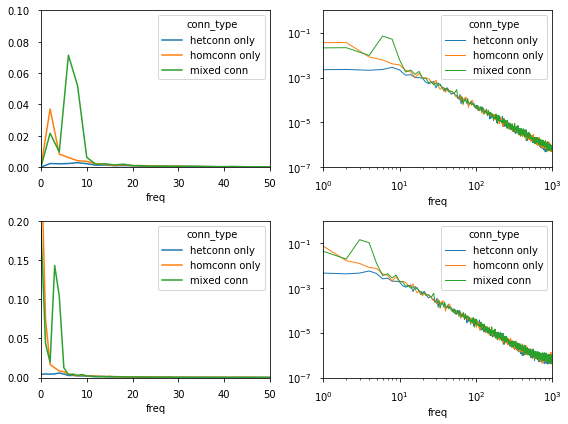

In [42]:
df_tp = pd.concat({'hetconn only': sim_hetconn.df_TotalPow.copy(),
                'homconn only': sim_homconn.df_TotalPow.copy(),
                'mixed conn': sim_mixedconn.df_TotalPow.copy()})
df_tp.index.names = ['conn_type', 'freq']
df_tp = df_tp.unstack('conn_type')
df_tp = df_tp[0]


df_tpp = pd.concat({'hetconn only': sim_hetconn.df_TotalPow_Per.copy(),
                'homconn only': sim_homconn.df_TotalPow_Per.copy(),
                'mixed conn': sim_mixedconn.df_TotalPow_Per.copy()})
df_tpp.index.names = ['conn_type', 'freq']
df_tpp = df_tpp.unstack('conn_type')
df_tpp = df_tpp[0]


fig, ax = plt.subplots(ncols=2,nrows=2,figsize=(8,6))

df_tpp.plot(xlim=[0,50],ylim=[0,0.1],ax=ax[0][0])
df_tpp.plot(ax=ax[0][1],logx=True,logy=True,
        ylim=[10E-8,10E-1],xlim=[10E-1,10E2],linewidth=1.)

df_tp.plot(xlim=[0,50],ylim=[0,0.2],ax=ax[1][0])
df_tp.plot(ax=ax[1][1],logx=True,logy=True,
        ylim=[10E-8,10E-1],xlim=[10E-1,10E2],linewidth=1.)

plt.tight_layout()

Note: plotting as a continuous line might be misleading re: the pattern at the top left 
      of the data. Also look at scatter plots:

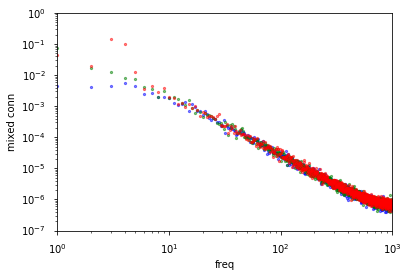

In [43]:
fig, ax = plt.subplots()

ylims =[10E-8,10E-1]
xlims =[10E-1,10E2]

df_tp.reset_index().plot(kind='scatter', x='freq',logx=True,logy=True,
                         xlim=xlims,ylim=ylims,ax=ax,linewidth=1.,
                         y='hetconn only',c='b',alpha=0.5,s=5.)
                         
df_tp.reset_index().plot(kind='scatter', x='freq',logx=True,logy=True,
                         xlim=xlims,ylim=ylims,ax=ax,
                         y='homconn only', c='g',alpha=0.5,s=5.);

df_tp.reset_index().plot(kind='scatter', x='freq',logx=True,logy=True,
                         xlim=xlims,ylim=ylims,ax=ax,
                         y='mixed conn', c='r',alpha=0.5,s=5.);

Run for longer

In [44]:
sim_mixedconnT500 = NF2pnt1D(T=500)#A1=0)
sim_mixedconnT500.run()
sim_mixedconnT500.compute_totalpow()
sim_mixedconnT500.compute_totalpow_per()

Number IDIM of spatial grid points is 31 

Number ndim of time points is 20001 

Maximal time delay is 3 

Max number IMAX of delay time points is 121 

WARNING  /nethome/kcni/jgriffiths/Software/miniconda3/envs/jupyter_py3/lib/python3.7/site-packages/ipykernel_launcher.py:328: RuntimeWarning: divide by zero encountered in true_divide

WARNING  /nethome/kcni/jgriffiths/Software/miniconda3/envs/jupyter_py3/lib/python3.7/site-packages/ipykernel_launcher.py:334: ComplexWarning: Casting complex values to real discards the imaginary part



In [45]:
sim_hetconnT500 = NF2pnt1D(A1=0,T=500)
sim_hetconnT500.run()
sim_hetconnT500.compute_totalpow()
sim_hetconnT500.compute_totalpow_per()

Number IDIM of spatial grid points is 31 

Number ndim of time points is 20001 

Maximal time delay is 3 

Max number IMAX of delay time points is 121 

WARNING  /nethome/kcni/jgriffiths/Software/miniconda3/envs/jupyter_py3/lib/python3.7/site-packages/ipykernel_launcher.py:328: RuntimeWarning: divide by zero encountered in true_divide

WARNING  /nethome/kcni/jgriffiths/Software/miniconda3/envs/jupyter_py3/lib/python3.7/site-packages/ipykernel_launcher.py:334: ComplexWarning: Casting complex values to real discards the imaginary part



In [46]:
sim_homconnT500 = NF2pnt1D(c12=0,c21=0,T=500)
sim_homconnT500.run()
sim_homconnT500.compute_totalpow()
sim_homconnT500.compute_totalpow_per()

Number IDIM of spatial grid points is 31 

Number ndim of time points is 20001 

Maximal time delay is 3 

Max number IMAX of delay time points is 121 

WARNING  /nethome/kcni/jgriffiths/Software/miniconda3/envs/jupyter_py3/lib/python3.7/site-packages/ipykernel_launcher.py:328: RuntimeWarning: divide by zero encountered in true_divide

WARNING  /nethome/kcni/jgriffiths/Software/miniconda3/envs/jupyter_py3/lib/python3.7/site-packages/ipykernel_launcher.py:334: ComplexWarning: Casting complex values to real discards the imaginary part



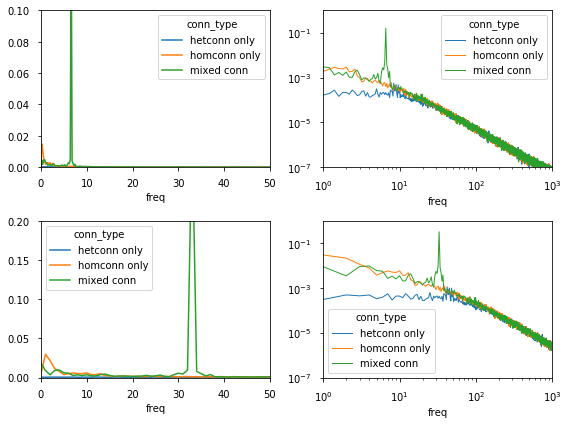

In [47]:
df_tpT500 = pd.concat({'hetconn only': sim_hetconnT500.df_TotalPow.copy(),
                    'homconn only': sim_homconnT500.df_TotalPow.copy(),
                    'mixed conn': sim_mixedconnT500.df_TotalPow.copy()})
df_tpT500.index.names = ['conn_type', 'freq']
df_tpT500 = df_tpT500.unstack('conn_type')
df_tpT500 = df_tpT500[0]


df_tppT500 = pd.concat({'hetconn only': sim_hetconnT500.df_TotalPow_Per.copy(),
                     'homconn only': sim_homconnT500.df_TotalPow_Per.copy(),
                     'mixed conn': sim_mixedconnT500.df_TotalPow_Per.copy()})
df_tppT500.index.names = ['conn_type', 'freq']
df_tppT500 = df_tppT500.unstack('conn_type')
df_tppT500 = df_tppT500[0]


fig, ax = plt.subplots(ncols=2,nrows=2,figsize=(8,6))

df_tppT500.plot(xlim=[0,50],ylim=[0,0.1],ax=ax[0][0])
df_tppT500.plot(ax=ax[0][1],logx=True,logy=True,
        ylim=[10E-8,10E-1],xlim=[10E-1,10E2],linewidth=1.)

df_tpT500.plot(xlim=[0,50],ylim=[0,0.2],ax=ax[1][0])
df_tpT500.plot(ax=ax[1][1],logx=True,logy=True,
        ylim=[10E-8,10E-1],xlim=[10E-1,10E2],linewidth=1.)

plt.tight_layout()

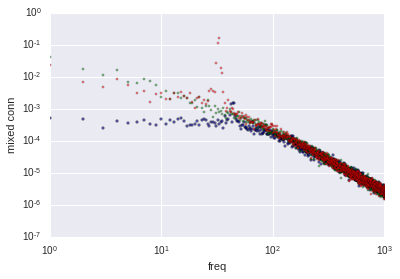

In [44]:
fig, ax = plt.subplots()

ylims =[10E-8,10E-1]
xlims =[10E-1,10E2]

df_tpT500.reset_index().plot(kind='scatter', x='freq',logx=True,logy=True,
                         xlim=xlims,ylim=ylims,ax=ax,linewidth=1.,
                         y='hetconn only',c='b',alpha=0.5,s=5.)
                         
df_tpT500.reset_index().plot(kind='scatter', x='freq',logx=True,logy=True,
                         xlim=xlims,ylim=ylims,ax=ax,
                         y='homconn only', c='g',alpha=0.5,s=5.);

df_tpT500.reset_index().plot(kind='scatter', x='freq',logx=True,logy=True,
                         xlim=xlims,ylim=ylims,ax=ax,
                         y='mixed conn', c='r',alpha=0.5,s=5.);

Save to file

In [25]:
df_tp.to_hdf(NF2pnt1D_outfile, 'df_tp')
df_tpp.to_hdf(NF2pnt1D_outfile, 'df_tpp')

In [45]:
df_tpT500.to_hdf(NF2pnt1D_outfile, 'df_tpT500')
df_tppT500.to_hdf(NF2pnt1D_outfile, 'df_tppT500')

We're working on the assumption that homogeneous-only connectivity and the mixed connectivity show more powerlaw-like power spectrum distributions than the purely heterogeneous connetivity. 

Confirm this statistically:

In [59]:
data = np.squeeze(df_tp[['homconn only']].values.copy())
data = data / data.min()
fit_homconn_findxmin = powerlaw.Fit(data, discrete=True)
print('homconn best xmin = %s;  D = %s' %(fit_homconn_findxmin.xmin,
                                          fit_homconn_findxmin.D))

fit_homconn_xmin0 = powerlaw.Fit(data, discrete=True,xmin=0)
print('homconn xmin 0; D = %s' %(fit_homconn_xmin0.D)) 

data = np.squeeze(df_tp[['hetconn only']].values.copy())
data = data / data.min()
fit_hetconn_findxmin = powerlaw.Fit(data, discrete=True)
print('hetconn best xmin = %s;  D = %s' %(fit_hetconn_findxmin.xmin,
                                          fit_hetconn_findxmin.D))

fit_hetconn_xmin0 = powerlaw.Fit(data, discrete=True,xmin=0)
print('hetconn xmin 0; D = %s' %(fit_hetconn_xmin0.D))

Calculating best minimal value for power law fit


homconn best xmin = 5.919110952670017;  D = 0.029794890119577533


Calculating best minimal value for power law fit


homconn xmin 0; D = 0.029794890119577533


Calculating best minimal value for power law fit


hetconn best xmin = 3.0987916340182946;  D = 0.01723486564231569


Calculating best minimal value for power law fit


hetconn xmin 0; D = 0.01723486564231569


In [60]:
data = np.squeeze(df_tp[['mixed conn']].values.copy())
data = data / data.min()
fit_mixedconn_findxmin = powerlaw.Fit(data, discrete=True)
print('mixedconn best xmin = %s;  D = %s' %(fit_mixedconn_findxmin.xmin,
                                            fit_mixedconn_findxmin.D))
fit_mixedconn_xmin0 = powerlaw.Fit(data, discrete=True,xmin=0)
print('mixedconn xmin 0; D = %s' %(fit_mixedconn_xmin0.D))
      

Calculating best minimal value for power law fit


mixedconn best xmin = 8.156604066220309;  D = 0.016934971354269024


Calculating best minimal value for power law fit


mixedconn xmin 0; D = 0.016934971354269024


In [63]:
data = np.squeeze(df_tp[['homconn only']].values.copy())
data = data / data.min()
fit_homconn_findxmin = powerlaw.Fit(data, discrete=True)
fit_homconn_xmin0 = powerlaw.Fit(data, discrete=True,xmin=0)
fit_homconn_xmin1 = powerlaw.Fit(data, discrete=True,xmin=1)
fit_homconn_xmin20 = powerlaw.Fit(data, discrete=True,xmin=20)
fit_homconn_x1to20 = powerlaw.Fit(data, discrete=True,xmin=1,xmax=20)

data = np.squeeze(df_tp[['hetconn only']].values.copy())
data = data / data.min()
fit_hetconn_findxmin = powerlaw.Fit(data, discrete=True)
fit_hetconn_xmin0 = powerlaw.Fit(data, discrete=True,xmin=0)
fit_hetconn_xmin1 = powerlaw.Fit(data, discrete=True,xmin=1)
fit_hetconn_xmin20 = powerlaw.Fit(data, discrete=True,xmin=20)
fit_hetconn_x1to20 = powerlaw.Fit(data, discrete=True,xmin=1,xmax=20)

data = np.squeeze(df_tp[['mixed conn']].values.copy())
data = data / data.min()
fit_mixedconn_findxmin = powerlaw.Fit(data, discrete=True)
fit_mixedconn_xmin0 = powerlaw.Fit(data, discrete=True,xmin=0)
fit_mixedconn_xmin1 = powerlaw.Fit(data, discrete=True,xmin=1)
fit_mixedconn_xmin20 = powerlaw.Fit(data, discrete=True,xmin=20)
fit_mixedconn_x1to20 = powerlaw.Fit(data, discrete=True,xmin=1,xmax=20)

Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


In [64]:
print('homconn best xmin = %s;  D = %s' %(fit_homconn_findxmin.xmin,
                                          fit_homconn_findxmin.D))
print('hetconn best xmin = %s;  D = %s' %(fit_hetconn_findxmin.xmin,
                                          fit_hetconn_findxmin.D))
print('mixedconn best xmin = %s;  D = %s' %(fit_mixedconn_findxmin.xmin,
                                            fit_mixedconn_findxmin.D))

print('\n')
print('homconn xmin 0; D = %s' %(fit_homconn_xmin0.D))
print('hetconn xmin 0; D = %s' %(fit_hetconn_xmin0.D))
print('mixedconn xmin 0; D = %s' %(fit_mixedconn_xmin0.D))

print('\n')
print('homconn xmin 1; D = %s' %(fit_homconn_xmin1.D))
print('hetconn xmin 1; D = %s' %(fit_hetconn_xmin1.D))
print('mixedconn xmin 1; D = %s' %(fit_mixedconn_xmin1.D))

print('\n')
print('homconn xmin 20; D = %s' %(fit_homconn_xmin20.D))
print('hetconn xmin 20; D = %s' %(fit_hetconn_xmin20.D))
print('mixedconn xmin 20; D = %s' %(fit_mixedconn_xmin20.D))

print('\n')
print('homconn x1to20; D = %s' %(fit_homconn_x1to20.D))
print('hetconn x1to20; D = %s' %(fit_hetconn_x1to20.D))
print('mixedconn x1to20; D = %s' %(fit_mixedconn_x1to20.D))

homconn best xmin = 5.919110952670017;  D = 0.029794890119577533
hetconn best xmin = 3.0987916340182946;  D = 0.01723486564231569
mixedconn best xmin = 8.156604066220309;  D = 0.016934971354269024


homconn xmin 0; D = 0.029794890119577533
hetconn xmin 0; D = 0.01723486564231569
mixedconn xmin 0; D = 0.016934971354269024


homconn xmin 1; D = 0.1560980047885709
hetconn xmin 1; D = 0.1310878923713628
mixedconn xmin 1; D = 0.16234606388557823


homconn xmin 20; D = 0.06647316895178532
hetconn xmin 20; D = 0.036401226120338415
mixedconn xmin 20; D = 0.03031960465198333


homconn x1to20; D = 0.13926859767973754
hetconn x1to20; D = 0.13659664463001353
mixedconn x1to20; D = 0.14909870012528104


These fits confirm our intuitions from the plots, that the purely heterogeneous connectivity model shows less power law-like behaviour than purely homogeneous and mixed connectivity, and that this is due to shape of the curves at the lower end. 

When we allow powerlaw to automatically find the best scaling range, it chooses an xmin of 6, 7.8, a,d 5.6 for homogeneous-only connecitvity, heterogeneous-only connectivity, and mixed connectivity, respectively; with fits of D = 0.0167,0.0234,0.0158. So for the optimal choice of xmin, the homogeoneous and mixed connectivities get better power law fits than the heterogeneous connectivity. 


When we constrain the minimum to be at 0 (need to check if that's correct to do...) or 1, both the homogeneous and mixed connectivities get better power law fits than the heterogeneous. 

Likewise, when we restrict the scaling range from 1 to 20, we also have better power law fits for homogeneous and mixed connectivity than heterogeneous connectivity. 

In some of the above (forcing xmin = 1 and restricting range from 1 to 20), the homogeneous connectivity also gives better fits than the mixed connectivity; also in line with our hypothesis that the local connectivity drives power law behaviour at the lower end. However this is probably due to the fact that we have the alpha peak in the mixed connectivity; which is possibly a bit of a confound in some of these comparisons.

Furthermore, when we constrain the scaling range to start from x=20, the homogeneous and heterogeneous connectivities get pretty much the same fit (although the mixed connectivity is better than both in this case). This further confirms that the neural field component is adding power law behaviour at the lower end of the spectrum only. 


All these conclusions are the same for continuous distribution fits:

In [65]:
data = np.squeeze(df_tp[['homconn only']].values.copy())
data = data / data.min()
fit_homconn_findxmin_cont = powerlaw.Fit(data, discrete=False)
fit_homconn_xmin0_cont = powerlaw.Fit(data, discrete=False,xmin=0)
fit_homconn_xmin1_cont = powerlaw.Fit(data, discrete=False,xmin=1)
fit_homconn_xmin20_cont = powerlaw.Fit(data, discrete=False,xmin=20)
fit_homconn_x1to20_cont = powerlaw.Fit(data, discrete=False,xmin=1,xmax=20)

data = np.squeeze(df_tp[['hetconn only']].values.copy())
data = data / data.min()
fit_hetconn_findxmin_cont = powerlaw.Fit(data, discrete=False)
fit_hetconn_xmin0_cont = powerlaw.Fit(data, discrete=False,xmin=0)
fit_hetconn_xmin1_cont = powerlaw.Fit(data, discrete=False,xmin=1)
fit_hetconn_xmin20_cont = powerlaw.Fit(data, discrete=False,xmin=20)
fit_hetconn_x1to20_cont = powerlaw.Fit(data, discrete=False,xmin=1,xmax=20)

data = np.squeeze(df_tp[['mixed conn']].values.copy())
data = data / data.min()
fit_mixedconn_findxmin_cont = powerlaw.Fit(data, discrete=False)
fit_mixedconn_xmin0_cont = powerlaw.Fit(data, discrete=False,xmin=0)
fit_mixedconn_xmin1_cont = powerlaw.Fit(data, discrete=False,xmin=1)
fit_mixedconn_xmin20_cont = powerlaw.Fit(data, discrete=False,xmin=20)
fit_mixedconn_x1to20_cont = powerlaw.Fit(data, discrete=False,xmin=1,xmax=20)

Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


In [66]:
print('homconn cont best xmin = %s;  D = %s' %(fit_homconn_findxmin_cont.xmin,
                                          fit_homconn_findxmin_cont.D))
print('hetconn cont best xmin = %s;  D = %s' %(fit_hetconn_findxmin_cont.xmin,
                                          fit_hetconn_findxmin_cont.D))
print('mixedconn cont best xmin = %s;  D = %s' %(fit_mixedconn_findxmin_cont.xmin,
                                            fit_mixedconn_findxmin_cont.D))

print('\n')
print('homconn cont xmin 0; D = %s' %(fit_homconn_xmin0_cont.D))
print('hetconn cont xmin 0; D = %s' %(fit_hetconn_xmin0_cont.D))
print('mixedconn cont xmin 0; D = %s' %(fit_mixedconn_xmin0_cont.D))

print('\n')
print('homconn cont xmin 1; D = %s' %(fit_homconn_xmin1_cont.D))
print('hetconn cont xmin 1; D = %s' %(fit_hetconn_xmin1_cont.D))
print('mixedconn cont xmin 1; D = %s' %(fit_mixedconn_xmin1_cont.D))

print('\n')
print('homconn cont xmin 20; D = %s' %(fit_homconn_xmin20_cont.D))
print('hetconn cont xmin 20; D = %s' %(fit_hetconn_xmin20_cont.D))
print('mixedconn cont xmin 20; D = %s' %(fit_mixedconn_xmin20_cont.D))

print('\n')
print('homconn cont x1to20; D = %s' %(fit_homconn_x1to20_cont.D))
print('hetconn cont x1to20; D = %s' %(fit_hetconn_x1to20_cont.D))
print('mixedconn cont x1to20; D = %s' %(fit_mixedconn_x1to20_cont.D))

homconn cont best xmin = 3.112792097293563;  D = 0.02535626353290754
hetconn cont best xmin = 3.089480348651174;  D = 0.019324603110897343
mixedconn cont best xmin = 5.03182764013096;  D = 0.015855503684993888


homconn cont xmin 0; D = 0.02535626353290754
hetconn cont xmin 0; D = 0.019324603110897343
mixedconn cont xmin 0; D = 0.015855503684993888


homconn cont xmin 1; D = 0.14459420581614102
hetconn cont xmin 1; D = 0.12032585523035008
mixedconn cont xmin 1; D = 0.15079980317503489


homconn cont xmin 20; D = 0.06512369933318338
hetconn cont xmin 20; D = 0.03584739310117285
mixedconn cont xmin 20; D = 0.031416487198495824


homconn cont x1to20; D = 0.2587471967186929
hetconn cont x1to20; D = 0.22856845187228347
mixedconn cont x1to20; D = 0.27099694834876487


Comparing alternative distributions: 
    
Power law distributions are favoured over exponentials in all cases, with high significance. But lognormal distributions are often favoured over power laws; and these are significant for xmin=1 (but not for optimized xmin).


Going from the spiel in Alstott's paper, I don't think this is a huge problem, as we have 'domain-specific theoretical reasoning' for expecting power laws but not lognormals (right??). 



In [68]:
# R is positive if the data is more likely in the first distribution, 
# and negative if the data is more ikely in the second sitribution
# p is significance value for that direction

R,p= fit_hetconn_findxmin.distribution_compare('power_law', 'exponential')
print('R = %s; p = %s' %(R,p))

R,p= fit_homconn_findxmin.distribution_compare('power_law', 'exponential')
print('R = %s; p = %s' %(R,p))

R,p= fit_mixedconn_findxmin.distribution_compare('power_law', 'exponential')
print('R = %s; p = %s' %(R,p))

R = 1014.0403174463668; p = 1.584163728020944e-33
R = 1302.972237430508; p = 7.279093381499898e-09
R = 1097.830682456405; p = 1.23011940489131e-18


In [69]:
R,p= fit_hetconn_xmin1.distribution_compare('power_law', 'exponential')
print('R = %s; p = %s' %(R,p))

R,p= fit_homconn_xmin1.distribution_compare('power_law', 'exponential')
print('R = %s; p = %s' %(R,p))

R,p= fit_mixedconn_xmin1.distribution_compare('power_law', 'exponential')
print('R = %s; p = %s' %(R,p))

R = 2304.815027755887; p = 1.5464160989284409e-37
R = 4243.587228765825; p = 1.185782659284138e-10
R = 4402.732976403957; p = 3.3629932508995716e-22


In [70]:
R,p= fit_hetconn_findxmin.distribution_compare('power_law', 'lognormal')
print('R = %s; p = %s' %(R,p))

R,p= fit_homconn_findxmin.distribution_compare('power_law', 'lognormal')
print('R = %s; p = %s' %(R,p))

R,p= fit_mixedconn_findxmin.distribution_compare('power_law', 'lognormal')
print('R = %s; p = %s' %(R,p))

R = -3.4649613590783117; p = 0.08439348137366853
R = -0.44348223054258895; p = 0.6016262642157528
R = -0.1544396789630733; p = 0.7584292019266619


In [71]:
R,p= fit_hetconn_xmin1.distribution_compare('power_law', 'lognormal')
print('R = %s; p = %s' %(R,p))

R,p= fit_homconn_xmin1.distribution_compare('power_law', 'lognormal')
print('R = %s; p = %s' %(R,p))

R,p= fit_mixedconn_xmin1.distribution_compare('power_law', 'lognormal')
print('R = %s; p = %s' %(R,p))

R = -44.061079915827364; p = 9.08357337733109e-05
R = -43.10340433401201; p = 0.0035225713429338436
R = -40.940557570272084; p = 0.008373058143781842


Now demonstrate the above distinction between the different model types parametrically. 


We vary the local coupling strength parameter A1 and local kernel width parameter sigma1 continuously, for both the mixed and purely homogeneous connectivity models. 


We find that the best power law fits are found for high values of A1 and intermediate values of sigma1, from the ranges studied; and also that sigma1 and A1 interact (i.e. the gradient in the PSE plots is tilted). 



In [75]:
# Increasing sigma reduces alpha spectral peak
A1s = 10**r_[-0.001:1:10j]
sigma1s = 10**r_[-0.001:1:10j]
combs = list(itertools.product(A1s,sigma1s))

_sims_pse1_mixedconn = {}
_sims_pse1_mixedconn_tpdfs = {}
#_sims_pse1_fits = {}
_sims_pse1_mixedconn_fit_Ds_findxmin = {}
_sims_pse1_mixedconn_fit_Ds_xmin0 = {}
_sims_pse1_mixedconn_fit_Ds_xmin1 = {}
_sims_pse1_mixedconn_fit_Ds_xmin20 = {}
_sims_pse1_mixedconn_fit_Ds_x1to20 = {}

In [77]:
len(combs)

100

In [76]:
for (A1,sigma1) in combs:
    
  s = NF2pnt1D(sigma1=sigma1,A1=A1) 
  s.run()
  s.compute_totalpow()
  s.compute_totalpow_per()

  _sims_pse1_mixedconn[A1,sigma1] = s
  _sims_pse1_mixedconn_tpdfs[A1,sigma1] = s.df_TotalPow
    
  data = np.squeeze(s.df_TotalPow.values.copy())
  data = data / data.min()
    
  _fit = powerlaw.Fit(data, discrete=True)
  _sims_pse1_mixedconn_fit_Ds_findxmin[A1,sigma1] = _fit.power_law.D    

  _fit = powerlaw.Fit(data, discrete=True,xmin=0)
  _sims_pse1_mixedconn_fit_Ds_xmin0[A1,sigma1] = _fit.power_law.D    

  _fit = powerlaw.Fit(data, discrete=True,xmin=1)    
  _sims_pse1_mixedconn_fit_Ds_xmin1[A1,sigma1] = _fit.power_law.D
    
  _fit = powerlaw.Fit(data, discrete=True,xmin=20)
  _sims_pse1_mixedconn_fit_Ds_xmin20[A1,sigma1] = _fit.power_law.D    
    
  _fit = powerlaw.Fit(data, discrete=True,xmin=1,xmax=20)    
  _sims_pse1_mixedconn_fit_Ds_x1to20[A1,sigma1] = _fit.power_law.D    
        
        
clear_output()

In [78]:
def doaplot(_s,_ax,_tit,vmin=0,vmax=0.2):
    
  _arr1 = np.array(_s.keys())        
  _arr2 = np.array(_s.values())[:,np.newaxis]
  _arr12 = np.concatenate([_arr1,_arr2],axis=1)
  _df = pd.DataFrame(_arr12,columns=['A1', 'sigma1', 'D'])
  sns.heatmap(_df.set_index(['A1', 'sigma1'])['D'].unstack(), ax=_ax,
              xticklabels='',yticklabels='',vmin=vmin,vmax=vmax)
  _ax.set_title(_tit)    
    

In [83]:
_sims_pse1_mixedconn_fit_Ds_findxmin.keys()

dict_keys([(0.9977000638225533, 0.9977000638225533), (0.9977000638225533, 1.2889088990821966), (0.9977000638225533, 1.6651158102248549), (0.9977000638225533, 2.151130047620192), (0.9977000638225533, 2.779002189132765), (0.9977000638225533, 3.5901377398119365), (0.9977000638225533, 4.638027649357204), (0.9977000638225533, 5.991775813406186), (0.9977000638225533, 7.740656182395769), (0.9977000638225533, 10.0), (1.2889088990821966, 0.9977000638225533), (1.2889088990821966, 1.2889088990821966), (1.2889088990821966, 1.6651158102248549), (1.2889088990821966, 2.151130047620192), (1.2889088990821966, 2.779002189132765), (1.2889088990821966, 3.5901377398119365), (1.2889088990821966, 4.638027649357204), (1.2889088990821966, 5.991775813406186), (1.2889088990821966, 7.740656182395769), (1.2889088990821966, 10.0), (1.6651158102248549, 0.9977000638225533), (1.6651158102248549, 1.2889088990821966), (1.6651158102248549, 1.6651158102248549), (1.6651158102248549, 2.151130047620192), (1.6651158102248549,

IndexError: too many indices for array

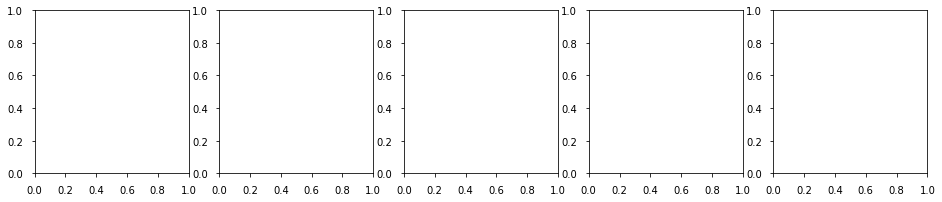

In [79]:
fig, ax = plt.subplots(ncols=5,figsize=(16,3))


_tit = 'findxmin'
_ax = ax[0]
_s = _sims_pse1_mixedconn_fit_Ds_findxmin 
doaplot(_s,_ax,_tit,vmin=0,vmax=0.02)


_tit = 'xmin0'
_ax = ax[1]
_s = _sims_pse1_mixedconn_fit_Ds_xmin0 
doaplot(_s,_ax,_tit,vmin=0,vmax=0.02)

_tit = 'xmin1'
_ax = ax[2]
_s = _sims_pse1_mixedconn_fit_Ds_xmin1
doaplot(_s,_ax,_tit,vmin=0,vmax=0.2)

_tit = 'xmin20'
_ax = ax[3]
_s = _sims_pse1_mixedconn_fit_Ds_xmin20
doaplot(_s,_ax,_tit,vmin=0,vmax=0.05)

_tit = 'x1to20'
_ax = ax[4]
_s = _sims_pse1_mixedconn_fit_Ds_x1to20
doaplot(_s,_ax,_tit,vmin=0,vmax=0.2)

plt.tight_layout()

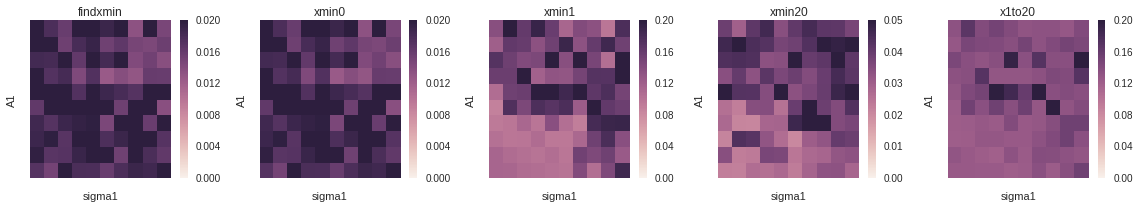

In [617]:
fig, ax = plt.subplots(ncols=5,figsize=(16,3))


_tit = 'findxmin'
_ax = ax[0]
_s = _sims_pse1_mixedconn_fit_Ds_findxmin 
doaplot(_s,_ax,_tit,vmin=0,vmax=0.02)


_tit = 'xmin0'
_ax = ax[1]
_s = _sims_pse1_mixedconn_fit_Ds_xmin0 
doaplot(_s,_ax,_tit,vmin=0,vmax=0.02)

_tit = 'xmin1'
_ax = ax[2]
_s = _sims_pse1_mixedconn_fit_Ds_xmin1
doaplot(_s,_ax,_tit,vmin=0,vmax=0.2)

_tit = 'xmin20'
_ax = ax[3]
_s = _sims_pse1_mixedconn_fit_Ds_xmin20
doaplot(_s,_ax,_tit,vmin=0,vmax=0.05)

_tit = 'x1to20'
_ax = ax[4]
_s = _sims_pse1_mixedconn_fit_Ds_x1to20
doaplot(_s,_ax,_tit,vmin=0,vmax=0.2)

plt.tight_layout()

In [84]:
# Increasing sigma reduces alpha spectral peak
A1s = 10**r_[-0.001:1:10j]
sigma1s = 10**r_[-0.001:1:10j]
combs = list(itertools.product(A1s,sigma1s))

_sims_pse1_homogconn = {}
_sims_pse1_homogconn_tpdfs = {}
#_sims_pse1_fits = {}
_sims_pse1_homogconn_fit_Ds_findxmin = {}
_sims_pse1_homogconn_fit_Ds_xmin0 = {}
_sims_pse1_homogconn_fit_Ds_xmin1 = {}
_sims_pse1_homogconn_fit_Ds_xmin20 = {}
_sims_pse1_homogconn_fit_Ds_x1to20 = {}


for (A1,sigma1) in combs:
    
  s = NF2pnt1D(sigma1=sigma1,A1=A1,c12=0,c21=0)
  s.run()
  s.compute_totalpow()
  s.compute_totalpow_per()

  _sims_pse1_homogconn[A1,sigma1] = s
  _sims_pse1_homogconn_tpdfs[A1,sigma1] = s.df_TotalPow
    
  data = np.squeeze(s.df_TotalPow.values.copy())
  data = data / data.min()
    
  _fit = powerlaw.Fit(data, discrete=True)
  _sims_pse1_homogconn_fit_Ds_findxmin[A1,sigma1] = _fit.power_law.D    

  _fit = powerlaw.Fit(data, discrete=True,xmin=0)
  _sims_pse1_homogconn_fit_Ds_xmin0[A1,sigma1] = _fit.power_law.D    

  _fit = powerlaw.Fit(data, discrete=True,xmin=1)    
  _sims_pse1_homogconn_fit_Ds_xmin1[A1,sigma1] = _fit.power_law.D
    
  _fit = powerlaw.Fit(data, discrete=True,xmin=20)
  _sims_pse1_homogconn_fit_Ds_xmin20[A1,sigma1] = _fit.power_law.D    
    
  _fit = powerlaw.Fit(data, discrete=True,xmin=1,xmax=20)    
  _sims_pse1_homogconn_fit_Ds_x1to20[A1,sigma1] = _fit.power_law.D    
        
        
clear_output()

IndexError: too many indices for array

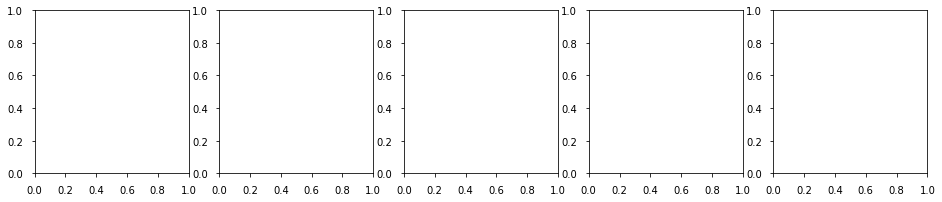

In [85]:
fig, ax = plt.subplots(ncols=5,figsize=(16,3))


_tit = 'findxmin'
_ax = ax[0]
_s = _sims_pse1_homogconn_fit_Ds_findxmin 
doaplot(_s,_ax,_tit,vmin=0,vmax=0.02)


_tit = 'xmin0'
_ax = ax[1]
_s = _sims_pse1_homogconn_fit_Ds_xmin0 
doaplot(_s,_ax,_tit,vmin=0,vmax=0.02)

_tit = 'xmin1'
_ax = ax[2]
_s = _sims_pse1_homogconn_fit_Ds_xmin1
doaplot(_s,_ax,_tit,vmin=0,vmax=0.2)

_tit = 'xmin20'
_ax = ax[3]
_s = _sims_pse1_homogconn_fit_Ds_xmin20
doaplot(_s,_ax,_tit,vmin=0,vmax=0.05)

_tit = 'x1to20'
_ax = ax[4]
_s = _sims_pse1_homogconn_fit_Ds_x1to20
doaplot(_s,_ax,_tit,vmin=0,vmax=0.2)

plt.tight_layout()

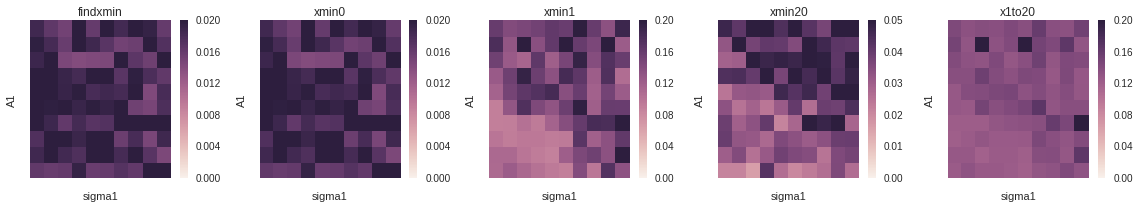

In [619]:
fig, ax = plt.subplots(ncols=5,figsize=(16,3))


_tit = 'findxmin'
_ax = ax[0]
_s = _sims_pse1_homogconn_fit_Ds_findxmin 
doaplot(_s,_ax,_tit,vmin=0,vmax=0.02)


_tit = 'xmin0'
_ax = ax[1]
_s = _sims_pse1_homogconn_fit_Ds_xmin0 
doaplot(_s,_ax,_tit,vmin=0,vmax=0.02)

_tit = 'xmin1'
_ax = ax[2]
_s = _sims_pse1_homogconn_fit_Ds_xmin1
doaplot(_s,_ax,_tit,vmin=0,vmax=0.2)

_tit = 'xmin20'
_ax = ax[3]
_s = _sims_pse1_homogconn_fit_Ds_xmin20
doaplot(_s,_ax,_tit,vmin=0,vmax=0.05)

_tit = 'x1to20'
_ax = ax[4]
_s = _sims_pse1_homogconn_fit_Ds_x1to20
doaplot(_s,_ax,_tit,vmin=0,vmax=0.2)

plt.tight_layout()

Now do for linear spacing; more combs...

In [ ]:
# Increasing sigma reduces alpha spectral peak
A1s = r_[0.1:10:0.1]
sigma1s = r_[0.1:10:0.1]
combs = list(itertools.product(A1s,sigma1s))

_sims_pse2_mixedconn = {}
_sims_pse2_mixedconn_tpdfs = {}
#_sims_pse1_fits = {}
_sims_pse2_mixedconn_fit_Ds_findxmin = {}
_sims_pse2_mixedconn_fit_Ds_xmin0 = {}
_sims_pse2_mixedconn_fit_Ds_xmin1 = {}
_sims_pse2_mixedconn_fit_Ds_xmin20 = {}
_sims_pse2_mixedconn_fit_Ds_x1to20 = {}


for (A1,sigma1) in combs:
    
  s = NF2pnt1D(sigma1=sigma1,A1=A1) 
  s.run()
  s.compute_totalpow()
  s.compute_totalpow_per()

  _sims_pse2_mixedconn[A1,sigma1] = s
  _sims_pse2_mixedconn_tpdfs[A1,sigma1] = s.df_TotalPow
    
  data = np.squeeze(s.df_TotalPow.values.copy())
  data = data / data.min()
    
  _fit = powerlaw.Fit(data, discrete=True)
  _sims_pse2_mixedconn_fit_Ds_findxmin[A1,sigma1] = _fit.power_law.D    

  _fit = powerlaw.Fit(data, discrete=True,xmin=0)
  _sims_pse2_mixedconn_fit_Ds_xmin0[A1,sigma1] = _fit.power_law.D    

  _fit = powerlaw.Fit(data, discrete=True,xmin=1)    
  _sims_pse2_mixedconn_fit_Ds_xmin1[A1,sigma1] = _fit.power_law.D
    
  _fit = powerlaw.Fit(data, discrete=True,xmin=20)
  _sims_pse2_mixedconn_fit_Ds_xmin20[A1,sigma1] = _fit.power_law.D    
    
  _fit = powerlaw.Fit(data, discrete=True,xmin=1,xmax=20)    
  _sims_pse2_mixedconn_fit_Ds_x1to20[A1,sigma1] = _fit.power_law.D    
        
        
clear_output() 

Number IDIM of spatial grid points is 31 

Number ndim of time points is 2001 

Maximal time delay is 3 

Max number IMAX of delay time points is 121 

WARNING  /nethome/kcni/jgriffiths/Software/miniconda3/envs/jupyter_py3/lib/python3.7/site-packages/ipykernel_launcher.py:328: RuntimeWarning: divide by zero encountered in true_divide

WARNING  /nethome/kcni/jgriffiths/Software/miniconda3/envs/jupyter_py3/lib/python3.7/site-packages/ipykernel_launcher.py:334: ComplexWarning: Casting complex values to real discards the imaginary part



Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Number IDIM of spatial grid points is 31 

Number ndim of time points is 2001 

Maximal time delay is 3 

Max number IMAX of delay time points is 121 



Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Number IDIM of spatial grid points is 31 

Number ndim of time points is 2001 

Maximal time delay is 3 

Max number IMAX of delay time points is 121 



Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Number IDIM of spatial grid points is 31 

Number ndim of time points is 2001 

Maximal time delay is 3 

Max number IMAX of delay time points is 121 



Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Number IDIM of spatial grid points is 31 

Number ndim of time points is 2001 

Maximal time delay is 3 

Max number IMAX of delay time points is 121 



Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Number IDIM of spatial grid points is 31 

Number ndim of time points is 2001 

Maximal time delay is 3 

Max number IMAX of delay time points is 121 



Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Number IDIM of spatial grid points is 31 

Number ndim of time points is 2001 

Maximal time delay is 3 

Max number IMAX of delay time points is 121 



Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Number IDIM of spatial grid points is 31 

Number ndim of time points is 2001 

Maximal time delay is 3 

Max number IMAX of delay time points is 121 



Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Number IDIM of spatial grid points is 31 

Number ndim of time points is 2001 

Maximal time delay is 3 

Max number IMAX of delay time points is 121 



Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Number IDIM of spatial grid points is 31 

Number ndim of time points is 2001 

Maximal time delay is 3 

Max number IMAX of delay time points is 121 



Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Number IDIM of spatial grid points is 31 

Number ndim of time points is 2001 

Maximal time delay is 3 

Max number IMAX of delay time points is 121 



Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Number IDIM of spatial grid points is 31 

Number ndim of time points is 2001 

Maximal time delay is 3 

Max number IMAX of delay time points is 121 



Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Number IDIM of spatial grid points is 31 

Number ndim of time points is 2001 

Maximal time delay is 3 

Max number IMAX of delay time points is 121 



Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Number IDIM of spatial grid points is 31 

Number ndim of time points is 2001 

Maximal time delay is 3 

Max number IMAX of delay time points is 121 



Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Number IDIM of spatial grid points is 31 

Number ndim of time points is 2001 

Maximal time delay is 3 

Max number IMAX of delay time points is 121 



Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Number IDIM of spatial grid points is 31 

Number ndim of time points is 2001 

Maximal time delay is 3 

Max number IMAX of delay time points is 121 



Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Number IDIM of spatial grid points is 31 

Number ndim of time points is 2001 

Maximal time delay is 3 

Max number IMAX of delay time points is 121 



Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Number IDIM of spatial grid points is 31 

Number ndim of time points is 2001 

Maximal time delay is 3 

Max number IMAX of delay time points is 121 



Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Number IDIM of spatial grid points is 31 

Number ndim of time points is 2001 

Maximal time delay is 3 

Max number IMAX of delay time points is 121 



Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Number IDIM of spatial grid points is 31 

Number ndim of time points is 2001 

Maximal time delay is 3 

Max number IMAX of delay time points is 121 



Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Number IDIM of spatial grid points is 31 

Number ndim of time points is 2001 

Maximal time delay is 3 

Max number IMAX of delay time points is 121 



Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Number IDIM of spatial grid points is 31 

Number ndim of time points is 2001 

Maximal time delay is 3 

Max number IMAX of delay time points is 121 



Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Number IDIM of spatial grid points is 31 

Number ndim of time points is 2001 

Maximal time delay is 3 

Max number IMAX of delay time points is 121 



Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Number IDIM of spatial grid points is 31 

Number ndim of time points is 2001 

Maximal time delay is 3 

Max number IMAX of delay time points is 121 



Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Number IDIM of spatial grid points is 31 

Number ndim of time points is 2001 

Maximal time delay is 3 

Max number IMAX of delay time points is 121 



Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Number IDIM of spatial grid points is 31 

Number ndim of time points is 2001 

Maximal time delay is 3 

Max number IMAX of delay time points is 121 



Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Number IDIM of spatial grid points is 31 

Number ndim of time points is 2001 

Maximal time delay is 3 

Max number IMAX of delay time points is 121 



Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Number IDIM of spatial grid points is 31 

Number ndim of time points is 2001 

Maximal time delay is 3 

Max number IMAX of delay time points is 121 



Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Number IDIM of spatial grid points is 31 

Number ndim of time points is 2001 

Maximal time delay is 3 

Max number IMAX of delay time points is 121 



Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Number IDIM of spatial grid points is 31 

Number ndim of time points is 2001 

Maximal time delay is 3 

Max number IMAX of delay time points is 121 



Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Number IDIM of spatial grid points is 31 

Number ndim of time points is 2001 

Maximal time delay is 3 

Max number IMAX of delay time points is 121 



Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Number IDIM of spatial grid points is 31 

Number ndim of time points is 2001 

Maximal time delay is 3 

Max number IMAX of delay time points is 121 



Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Number IDIM of spatial grid points is 31 

Number ndim of time points is 2001 

Maximal time delay is 3 

Max number IMAX of delay time points is 121 



Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Number IDIM of spatial grid points is 31 

Number ndim of time points is 2001 

Maximal time delay is 3 

Max number IMAX of delay time points is 121 



Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Number IDIM of spatial grid points is 31 

Number ndim of time points is 2001 

Maximal time delay is 3 

Max number IMAX of delay time points is 121 



Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Number IDIM of spatial grid points is 31 

Number ndim of time points is 2001 

Maximal time delay is 3 

Max number IMAX of delay time points is 121 



Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Number IDIM of spatial grid points is 31 

Number ndim of time points is 2001 

Maximal time delay is 3 

Max number IMAX of delay time points is 121 



Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Number IDIM of spatial grid points is 31 

Number ndim of time points is 2001 

Maximal time delay is 3 

Max number IMAX of delay time points is 121 



Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Number IDIM of spatial grid points is 31 

Number ndim of time points is 2001 

Maximal time delay is 3 

Max number IMAX of delay time points is 121 



Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Number IDIM of spatial grid points is 31 

Number ndim of time points is 2001 

Maximal time delay is 3 

Max number IMAX of delay time points is 121 



Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Number IDIM of spatial grid points is 31 

Number ndim of time points is 2001 

Maximal time delay is 3 

Max number IMAX of delay time points is 121 



Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Number IDIM of spatial grid points is 31 

Number ndim of time points is 2001 

Maximal time delay is 3 

Max number IMAX of delay time points is 121 



Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Number IDIM of spatial grid points is 31 

Number ndim of time points is 2001 

Maximal time delay is 3 

Max number IMAX of delay time points is 121 



Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Number IDIM of spatial grid points is 31 

Number ndim of time points is 2001 

Maximal time delay is 3 

Max number IMAX of delay time points is 121 



Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Number IDIM of spatial grid points is 31 

Number ndim of time points is 2001 

Maximal time delay is 3 

Max number IMAX of delay time points is 121 



Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Number IDIM of spatial grid points is 31 

Number ndim of time points is 2001 

Maximal time delay is 3 

Max number IMAX of delay time points is 121 



Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Number IDIM of spatial grid points is 31 

Number ndim of time points is 2001 

Maximal time delay is 3 

Max number IMAX of delay time points is 121 



Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Number IDIM of spatial grid points is 31 

Number ndim of time points is 2001 

Maximal time delay is 3 

Max number IMAX of delay time points is 121 



Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Number IDIM of spatial grid points is 31 

Number ndim of time points is 2001 

Maximal time delay is 3 

Max number IMAX of delay time points is 121 



Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Number IDIM of spatial grid points is 31 

Number ndim of time points is 2001 

Maximal time delay is 3 

Max number IMAX of delay time points is 121 



Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Number IDIM of spatial grid points is 31 

Number ndim of time points is 2001 

Maximal time delay is 3 

Max number IMAX of delay time points is 121 



Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Number IDIM of spatial grid points is 31 

Number ndim of time points is 2001 

Maximal time delay is 3 

Max number IMAX of delay time points is 121 



Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Number IDIM of spatial grid points is 31 

Number ndim of time points is 2001 

Maximal time delay is 3 

Max number IMAX of delay time points is 121 



Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Number IDIM of spatial grid points is 31 

Number ndim of time points is 2001 

Maximal time delay is 3 

Max number IMAX of delay time points is 121 



Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Number IDIM of spatial grid points is 31 

Number ndim of time points is 2001 

Maximal time delay is 3 

Max number IMAX of delay time points is 121 



Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Number IDIM of spatial grid points is 31 

Number ndim of time points is 2001 

Maximal time delay is 3 

Max number IMAX of delay time points is 121 



Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Number IDIM of spatial grid points is 31 

Number ndim of time points is 2001 

Maximal time delay is 3 

Max number IMAX of delay time points is 121 



Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Number IDIM of spatial grid points is 31 

Number ndim of time points is 2001 

Maximal time delay is 3 

Max number IMAX of delay time points is 121 



Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Number IDIM of spatial grid points is 31 

Number ndim of time points is 2001 

Maximal time delay is 3 

Max number IMAX of delay time points is 121 



Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Number IDIM of spatial grid points is 31 

Number ndim of time points is 2001 

Maximal time delay is 3 

Max number IMAX of delay time points is 121 



Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Number IDIM of spatial grid points is 31 

Number ndim of time points is 2001 

Maximal time delay is 3 

Max number IMAX of delay time points is 121 



Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Number IDIM of spatial grid points is 31 

Number ndim of time points is 2001 

Maximal time delay is 3 

Max number IMAX of delay time points is 121 



Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Number IDIM of spatial grid points is 31 

Number ndim of time points is 2001 

Maximal time delay is 3 

Max number IMAX of delay time points is 121 



Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Number IDIM of spatial grid points is 31 

Number ndim of time points is 2001 

Maximal time delay is 3 

Max number IMAX of delay time points is 121 



Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Number IDIM of spatial grid points is 31 

Number ndim of time points is 2001 

Maximal time delay is 3 

Max number IMAX of delay time points is 121 



Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Number IDIM of spatial grid points is 31 

Number ndim of time points is 2001 

Maximal time delay is 3 

Max number IMAX of delay time points is 121 



Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Number IDIM of spatial grid points is 31 

Number ndim of time points is 2001 

Maximal time delay is 3 

Max number IMAX of delay time points is 121 



Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Number IDIM of spatial grid points is 31 

Number ndim of time points is 2001 

Maximal time delay is 3 

Max number IMAX of delay time points is 121 



Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Number IDIM of spatial grid points is 31 

Number ndim of time points is 2001 

Maximal time delay is 3 

Max number IMAX of delay time points is 121 



Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Number IDIM of spatial grid points is 31 

Number ndim of time points is 2001 

Maximal time delay is 3 

Max number IMAX of delay time points is 121 



Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Number IDIM of spatial grid points is 31 

Number ndim of time points is 2001 

Maximal time delay is 3 

Max number IMAX of delay time points is 121 



Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Number IDIM of spatial grid points is 31 

Number ndim of time points is 2001 

Maximal time delay is 3 

Max number IMAX of delay time points is 121 



In [ ]:
fig, ax = plt.subplots(ncols=5,figsize=(16,3))


_tit = 'findxmin'
_ax = ax[0]
_s = _sims_pse2_mixedconn_fit_Ds_findxmin 
doaplot(_s,_ax,_tit,vmin=0,vmax=0.02)


_tit = 'xmin0'
_ax = ax[1]
_s = _sims_pse2_mixedconn_fit_Ds_xmin0 
doaplot(_s,_ax,_tit,vmin=0,vmax=0.02)

_tit = 'xmin1'
_ax = ax[2]
_s = _sims_pse2_mixedconn_fit_Ds_xmin1
doaplot(_s,_ax,_tit,vmin=0,vmax=0.2)

_tit = 'xmin20'
_ax = ax[3]
_s = _sims_pse2_mixedconn_fit_Ds_xmin20
doaplot(_s,_ax,_tit,vmin=0,vmax=0.05)

_tit = 'x1to20'
_ax = ax[4]
_s = _sims_pse2_mixedconn_fit_Ds_x1to20
doaplot(_s,_ax,_tit,vmin=0,vmax=0.2)

plt.tight_layout()

In [ ]:
# Increasing sigma reduces alpha spectral peak
A1s = r_[0.1:10:0.1]
sigma1s = r_[0.1:10:0.1]
combs = list(itertools.product(A1s,sigma1s))

_sims_pse2_homogconn = {}
_sims_pse2_homogconn_tpdfs = {}
#_sims_pse1_fits = {}
_sims_pse2_homogconn_fit_Ds_findxmin = {}
_sims_pse2_homogconn_fit_Ds_xmin0 = {}
_sims_pse2_homogconn_fit_Ds_xmin1 = {}
_sims_pse2_homogconn_fit_Ds_xmin20 = {}
_sims_pse2_homogconn_fit_Ds_x1to20 = {}


for (A1,sigma1) in combs:
    
  s = NF2pnt1D(sigma1=sigma1,A1=A1,c12=0,c21=0)
  s.run()
  s.compute_totalpow()
  s.compute_totalpow_per()

  _sims_pse2_homogconn[A1,sigma1] = s
  _sims_pse2_homogconn_tpdfs[A1,sigma1] = s.df_TotalPow
    
  data = np.squeeze(s.df_TotalPow.values.copy())
  data = data / data.min()
    
  _fit = powerlaw.Fit(data, discrete=True)
  _sims_pse2_homogconn_fit_Ds_findxmin[A1,sigma1] = _fit.power_law.D    

  _fit = powerlaw.Fit(data, discrete=True,xmin=0)
  _sims_pse2_homogconn_fit_Ds_xmin0[A1,sigma1] = _fit.power_law.D    

  _fit = powerlaw.Fit(data, discrete=True,xmin=1)    
  _sims_pse2_homogconn_fit_Ds_xmin1[A1,sigma1] = _fit.power_law.D
    
  _fit = powerlaw.Fit(data, discrete=True,xmin=20)
  _sims_pse2_homogconn_fit_Ds_xmin20[A1,sigma1] = _fit.power_law.D    
    
  _fit = powerlaw.Fit(data, discrete=True,xmin=1,xmax=20)    
  _sims_pse2_homogconn_fit_Ds_x1to20[A1,sigma1] = _fit.power_law.D    
        
        
clear_output()

In [ ]:
fig, ax = plt.subplots(ncols=5,figsize=(16,3))


_tit = 'findxmin'
_ax = ax[0]
_s = _sims_pse2_homogconn_fit_Ds_findxmin 
doaplot(_s,_ax,_tit,vmin=0,vmax=0.02)


_tit = 'xmin0'
_ax = ax[1]
_s = _sims_pse2_homogconn_fit_Ds_xmin0 
doaplot(_s,_ax,_tit,vmin=0,vmax=0.02)

_tit = 'xmin1'
_ax = ax[2]
_s = _sims_pse2_homogconn_fit_Ds_xmin1
doaplot(_s,_ax,_tit,vmin=0,vmax=0.2)

_tit = 'xmin20'
_ax = ax[3]
_s = _sims_pse2_homogconn_fit_Ds_xmin20
doaplot(_s,_ax,_tit,vmin=0,vmax=0.05)

_tit = 'x1to20'
_ax = ax[4]
_s = _sims_pse2_homogconn_fit_Ds_x1to20
doaplot(_s,_ax,_tit,vmin=0,vmax=0.2)

plt.tight_layout()

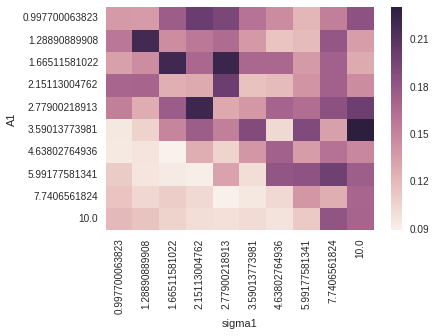

In [541]:
_arr1 = np.array(_sims_pse_fit_Ds.keys())        
_arr2 = np.array(_sims_pse_fit_Ds.values())[:,np.newaxis]
_arr12 = np.concatenate([_arr1,_arr2],axis=1)
_df = pd.DataFrame(_arr12,columns=['A1', 'sigma1', 'D'])
sns.heatmap(_df.set_index(['A1', 'sigma1'])['D'].unstack())

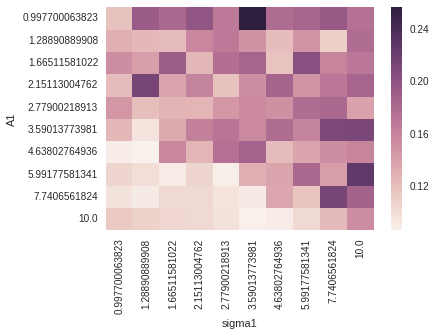

In [544]:
_arr1 = np.array(_sims_homogconn_pse_fit_Ds.keys())        
_arr2 = np.array(_sims_homogconn_pse_fit_Ds.values())[:,np.newaxis]
_arr12 = np.concatenate([_arr1,_arr2],axis=1)
_df = pd.DataFrame(_arr12,columns=['A1', 'sigma1', 'D'])
sns.heatmap(_df.set_index(['A1', 'sigma1'])['D'].unstack())

In [ ]:
# Increasing sigma reduces alpha spectral peak
A1s = 10**r_[-0.001:1:10j]
sigma1s = 10**r_[-0.001:1:10j]
combs = list(itertools.product(A1s,sigma1s))

_sims_homogconn_pse = {}
_sims_homogconn_pse_tpdfs = {}
_sims_homogconn_pse_fits = {}
_sims_homogconn_pse_fit_Ds = {}
for (A1,sigma1) in combs:
    
  s = NF2pnt1D(sigma1=sigma1,A1=A1,c12=0,c21=0)
  s.run()
  s.compute_totalpow()
  s.compute_totalpow_per()

  _sims_homogconn_pse[A1,sigma1] = s
  _sims_homogconn_pse_tpdfs[A1,sigma1] = s.df_TotalPow
    
  data = np.squeeze(s.df_TotalPow.values.copy())
  data = data / data.min()
    
  _fit = powerlaw.Fit(data, discrete=True,xmin=1)
  _sims_homogconn_pse_fits[A1,sigma1] = _fit
    
  _sims_homogconn_pse_fit_Ds[A1,sigma1] = _fit.power_law.D    
        
clear_output()



_arr1 = np.array(_sims_homogconn_pse_fit_Ds.keys())        
_arr2 = np.array(_sims_homogconn_pse_fit_Ds.values())[:,np.newaxis]
_arr12 = np.concatenate([_arr1,_arr2],axis=1)
_df = pd.DataFrame(_arr12,columns=['A1', 'sigma1', 'D'])
sns.heatmap(_df.set_index(['A1', 'sigma1'])['D'].unstack())

Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


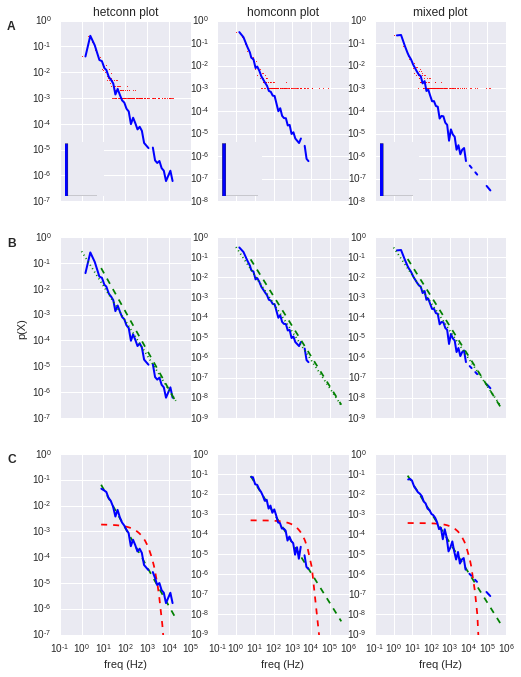

In [346]:
# Q: Why do these not show the spectral peaks so well, and 
#    why does it look if anything like the het conn is the mixed conn
#    plots from above??

n_data = 3
n_graphs = 3
f = figure(figsize=(8,11))

data = df_tp['hetconn only'].copy().values 
data = data / data.min()
data_inst = 1
units = 'freq (Hz)'
plot_basics(data, data_inst, f, units)


f.axes[-4].set_title('hetconn plot')


data = df_tp['homconn only'].copy().values 
data = data / data.min()
data_inst = 2
units = 'freq (Hz)'
plot_basics(data, data_inst, f, units)

f.axes[-4].set_title('homconn plot')


data = df_tp['mixed conn'].copy().values 
data = data / data.min()
data_inst = 3
units = 'freq (Hz)'
plot_basics(data, data_inst, f, units)

f.axes[-4].set_title('mixed plot')


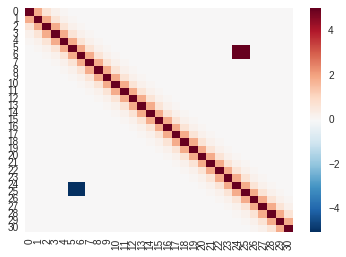

In [17]:
sns.heatmap(sim.w)

Vary connectivity strength / width for the mixed type

In [ ]:
# Increasing sigma reduces alpha spectral peak

sigma1s = [0.001,0.005,0.01,0.05,0.1,0.5,1.0]

_sims_varsigma1 = {}
_sims_varsigma1_tpdfs = {}
for sigma1 in sigma1s:
    
  s = NF2pnt1D(sigma1=sigma1) 
  s.run()
  s.compute_totalpow()
  s.compute_totalpow_per()

  _sims_varsigma1[sigma1] = s
  _sims_varsigma1_tpdfs[sigma1] = s.df_TotalPow
    
clear_output()


_sims_varsigma1_tpdfs_cat = pd.concat(_sims_varsigma1_tpdfs)[0].unstack().T
_sims_varsigma1_tpdfs_cat.columns.names = ['sigma1']
_sims_varsigma1_tpdfs_cat.index.names = ['freq']

fig, ax = plt.subplots();
_sims_varsigma1_tpdfs_cat.plot(ax=ax,logx=True,logy=True,
        ylim=[10E-8,10E1],xlim=[10E-1,10E2],linewidth=1.);

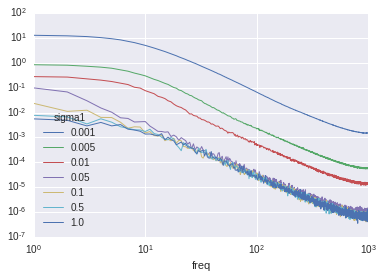

In [149]:
# Increasing sigma reduces alpha spectral peak

sigma1s = [0.001,0.005,0.01,0.05,0.1,0.5,1.0]

_sims_varsigma1_homog = {}
_sims_varsigma1_homog_tpdfs = {}
for sigma1 in sigma1s:
    
  s = NF2pnt1D(sigma1=sigma1,c12=0,c21=0)
  s.run()
  s.compute_totalpow()
  s.compute_totalpow_per()

  _sims_varsigma1_homog[sigma1] = s
  _sims_varsigma1_homog_tpdfs[sigma1] = s.df_TotalPow
    
clear_output()


_sims_varsigma1_homog_tpdfs_cat = pd.concat(_sims_varsigma1_homog_tpdfs)[0].unstack().T
_sims_varsigma1_homog_tpdfs_cat.columns.names = ['sigma1']
_sims_varsigma1_homog_tpdfs_cat.index.names = ['freq']

fig, ax = plt.subplots();
_sims_varsigma1_homog_tpdfs_cat.plot(ax=ax,logx=True,logy=True,
        ylim=[10E-8,10E1],xlim=[10E-1,10E2],linewidth=1.);

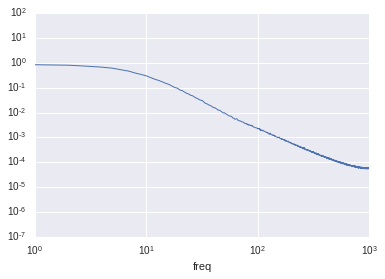

In [367]:
_sims_varsigma1_homog_tpdfs_cat[0.005].plot(logx=True,logy=True,
        ylim=[10E-8,10E1],xlim=[10E-1,10E2],linewidth=1.);

In [363]:
sigma1s =_sims_varsigma1_homog_tpdfs_cat.columns

_sims_varsigma1_homog_plfits= {}
for sigma1 in sigma1s:
    
  data = _sims_varsigma1_homog_tpdfs_cat[sigma1].values.copy()
  data = data / data.min()

  _fit = powerlaw.Fit(data, discrete=True)
  _sims_varsigma1_homog_plfits[sigma1] = _fit
    
  print 'D for sigma1=%s: %s' %(sigma1,_fit.power_law.D)

Calculating best minimal value for power law fit
Calculating best minimal value for power law fit

D for sigma1=0.001: 0.017160626527
D for sigma1=0.005: 0.0160438417326


Calculating best minimal value for power law fit


D for sigma1=0.01: 0.0175421427322


Calculating best minimal value for power law fit


D for sigma1=0.05: 0.0243106636139


Calculating best minimal value for power law fit


D for sigma1=0.1: 0.0213417786875


Calculating best minimal value for power law fit


D for sigma1=0.5: 0.0203395730672


Calculating best minimal value for power law fit


D for sigma1=1.0: 0.0216757382413


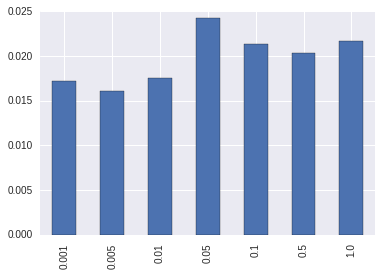

In [392]:
# Best power law fits for lowest values of sigma1

_sims_varsigma1_homog_plfits_Ds = {k: v.power_law.D for k,v in _sims_varsigma1_homog_plfits.items()}
_df = pd.DataFrame(_sims_varsigma1_homog_plfits_Ds.values(),
             index=_sims_varsigma1_homog_plfits_Ds.keys())[0]
#(_df.sort_index()*-1).plot(kind='bar',logy=True)
_df.sort_index().plot(kind='bar')

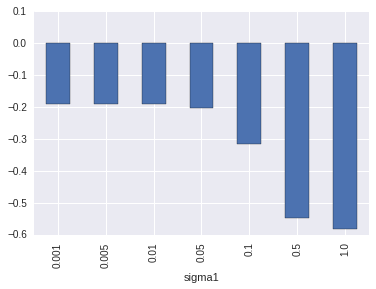

In [161]:
_sims_varsigma1_homog_tpdfs_cat_logidx = _sims_varsigma1_homog_tpdfs_cat.copy()
_sims_varsigma1_homog_tpdfs_cat_logidx.index = np.log1p(_sims_varsigma1_homog_tpdfs_cat_logidx.index)
_sims_varsigma1_homog_tpdfs_cat_logidx.reset_index().corr()['freq'][sigma1s].plot(kind='bar')

In [369]:
sigma1s =_sims_varsigma1_tpdfs_cat.columns

_sims_varsigma1_plfits= {}
for sigma1 in sigma1s:
  _fit = powerlaw.Fit(_sims_varsigma1_tpdfs_cat[sigma1], discrete=True)
  _sims_varsigma1_plfits[sigma1] = _fit
    
  print 'D for sigma1=%s: %s' %(sigma1,_fit.power_law.D)

Calculating best minimal value for power law fit
Calculating best minimal value for power law fit

D for sigma1=0.001: 0.0882348321355
D for sigma1=0.005: 0.10559772907


Calculating best minimal value for power law fit


D for sigma1=0.01: 0.111485698707


Calculating best minimal value for power law fit


D for sigma1=0.05: 0.0108776578852


Calculating best minimal value for power law fit


D for sigma1=0.1: 0.0109547146394


Calculating best minimal value for power law fit


D for sigma1=0.5: 0.129451406594


Calculating best minimal value for power law fit


D for sigma1=1.0: 0.121221322523


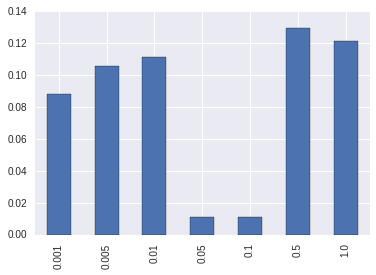

In [394]:
_sims_varsigma1_plfits_Ds = {k: v.power_law.D for k,v in _sims_varsigma1_plfits.items()}
_df = pd.DataFrame(_sims_varsigma1_plfits_Ds.values(),
             index=_sims_varsigma1_plfits_Ds.keys())[0]
_df.sort_index().plot(kind='bar')#,logy=True)

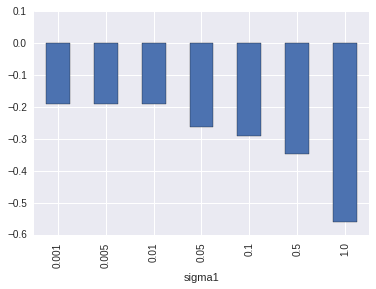

In [159]:
_sims_varsigma1_tpdfs_cat_logidx = _sims_varsigma1_tpdfs_cat.copy()
_sims_varsigma1_tpdfs_cat_logidx.index = np.log1p(_sims_varsigma1_tpdfs_cat_logidx.index)
_sims_varsigma1_tpdfs_cat_logidx.reset_index().corr()['freq'][sigma1s].plot(kind='bar')

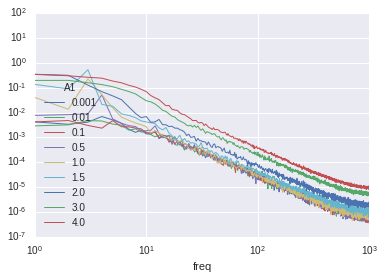

In [53]:
# Increasing sigma reduces alpha spectral peak

A1s= [0.001,0.01,0.1,0.5,1.0, 1.5, 2.0, 3.0,4.0]

_sims_varA1 = {}
_sims_varA1_tpdfs = {}
for A1 in A1s:
    
  s = NF2pnt1D(A1=A1)
  s.run()
  s.compute_totalpow()
  s.compute_totalpow_per()

  _sims_varA1[A1] = s
  _sims_varA1_tpdfs[A1] = s.df_TotalPow
    
clear_output()


_sims_varA1_tpdfs_cat = pd.concat(_sims_varA1_tpdfs)[0].unstack().T
_sims_varA1_tpdfs_cat.columns.names = ['A1']
_sims_varA1_tpdfs_cat.index.names = ['freq']

fig, ax = plt.subplots()
_sims_varA1_tpdfs_cat.plot(ax=ax,logx=True,logy=True,
        ylim=[10E-8,10E1],xlim=[10E-1,10E2],linewidth=1.)

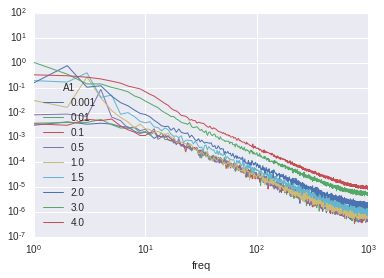

In [77]:
# Increasing sigma reduces alpha spectral peak

A1s= [0.001,0.01,0.1,0.5,1.0, 1.5, 2.0, 3.0,4.0]

_sims_varA1 = {}
_sims_varA1_tpdfs = {}
for A1 in A1s:
    
  s = NF2pnt1D(A1=A1)
  s.run()
  s.compute_totalpow()
  s.compute_totalpow_per()

  _sims_varA1[A1] = s
  _sims_varA1_tpdfs[A1] = s.df_TotalPow
    
clear_output()


_sims_varA1_tpdfs_cat = pd.concat(_sims_varA1_tpdfs)[0].unstack().T
_sims_varA1_tpdfs_cat.columns.names = ['A1']
_sims_varA1_tpdfs_cat.index.names = ['freq']

fig, ax = plt.subplots()
_sims_varA1_tpdfs_cat.plot(ax=ax,logx=True,logy=True,
        ylim=[10E-8,10E1],xlim=[10E-1,10E2],linewidth=1.)

In [59]:
_sims_varA1_tpdfs_cat.to_hdf(outfile,'_sims_varA1_tpdfs_cat')

In [288]:
A1 = A1s[3]

data = _sims_varA1_tpdfs_cat[A1].copy().values
data = data / data.min()
    
_fit = powerlaw.Fit(data, discrete=True)
#_fit.loglikelihood_ratio
_fit.loglikelihood_ratio

Calculating best minimal value for power law fit


<bound method Fit.loglikelihood_ratio of <powerlaw.Fit object at 0x7f472e7ecd10>>

In [290]:
_fit = powerlaw.Fit(data, discrete=True)

Calculating best minimal value for power law fit


In [294]:
_fit.estimate_discrete

True

In [396]:
A1s =_sims_varA1_tpdfs_cat.columns

_sims_varA1_plfits= {}
for A1 in A1s:
  data = _sims_varA1_tpdfs_cat[A1].copy().values
  data = data / data.min()
    
  _fit = powerlaw.Fit(data, discrete=True)
  _sims_varA1_plfits[A1] = _fit
    
  print 'D fit for A1=%s: %s' %(A1,_fit.power_law.D)


Calculating best minimal value for power law fit
Calculating best minimal value for power law fit

D fit for A1=0.001: 0.020659348708
D fit for A1=0.01: 0.0239965024398


Calculating best minimal value for power law fit


D fit for A1=0.1: 0.0231137345992


Calculating best minimal value for power law fit


D fit for A1=0.5: 0.0161448917764


Calculating best minimal value for power law fit


D fit for A1=1.0: 0.0235171836298


Calculating best minimal value for power law fit


D fit for A1=1.5: 0.0204696835163


Calculating best minimal value for power law fit


D fit for A1=2.0: 0.0231484927116


Calculating best minimal value for power law fit


D fit for A1=3.0: 0.020413858709


Calculating best minimal value for power law fit


D fit for A1=4.0: 0.0168969611643


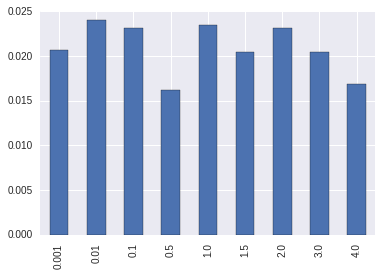

In [397]:
# No clear trend in power law fits with increasing or decreasing A here...

_sims_varA1_plfits_Ds = {k: v.power_law.D for k,v in _sims_varA1_plfits.items()}
_df = pd.DataFrame(_sims_varA1_plfits_Ds.values(),
             index=_sims_varA1_plfits_Ds.keys())[0]
_df.sort_index().plot(kind='bar')#,logy=True)

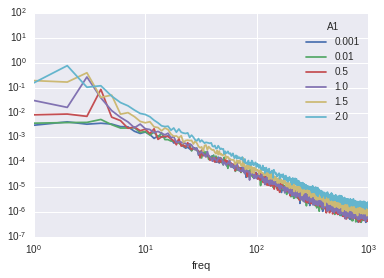

In [131]:
_sims_varA1_tpdfs_cat[[0.001,0.01,0.5,1.0,1.5,2.0]].plot(logx=True,logy=True)

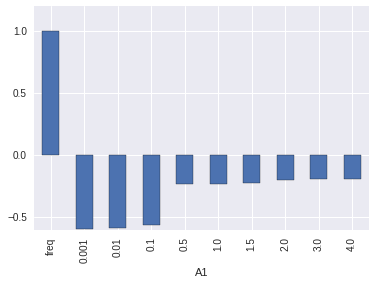

In [130]:
_sims_varA1_tpdfs_cat_logidx = _sims_varA1_tpdfs_cat.copy()
_sims_varA1_tpdfs_cat_logidx.index = np.log1p(_sims_varA1_tpdfs_cat_logidx.index)
_sims_varA1_tpdfs_cat_logidx.reset_index().corr()['freq'].plot(kind='bar')

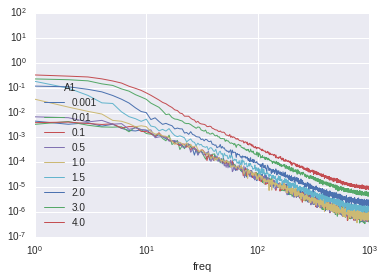

In [57]:
# Increasing sigma reduces alpha spectral peak

A1s= [0.001,0.01,0.1,0.5,1.0, 1.5, 2.0, 3.0,4.0]

_sims_varA1_homog = {}
_sims_varA1_homog_tpdfs = {}
for A1 in A1s:
    
  s = NF2pnt1D(A1=A1,c12=0,c21=0)
  s.run()
  s.compute_totalpow()
  s.compute_totalpow_per()

  _sims_varA1_homog[A1] = s
  _sims_varA1_homog_tpdfs[A1] = s.df_TotalPow
    
clear_output()


_sims_varA1_homog_tpdfs_cat = pd.concat(_sims_varA1_homog_tpdfs)[0].unstack().T
_sims_varA1_homog_tpdfs_cat.columns.names = ['A1']
_sims_varA1_homog_tpdfs_cat.index.names = ['freq']

fig, ax = plt.subplots()
_sims_varA1_homog_tpdfs_cat.plot(ax=ax,logx=True,logy=True,
        ylim=[10E-8,10E1],xlim=[10E-1,10E2],linewidth=1.)

In [60]:
_sims_varA1_homog_tpdfs_cat.to_hdf(outfile,'_sims_varA1_homog_tpdfs_cat')

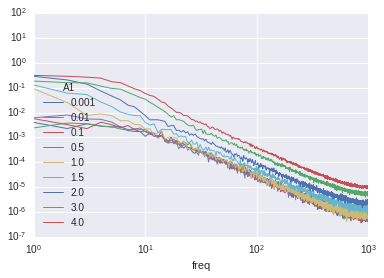

In [150]:
# Increasing sigma reduces alpha spectral peak

A1s= [0.001,0.01,0.1,0.5,1.0, 1.5, 2.0, 3.0,4.0]

_sims_varA1_homog = {}
_sims_varA1_homog_tpdfs = {}
for A1 in A1s:
    
  s = NF2pnt1D(A1=A1,c12=0,c21=0)
  s.run()
  s.compute_totalpow()
  s.compute_totalpow_per()

  _sims_varA1_homog[A1] = s
  _sims_varA1_homog_tpdfs[A1] = s.df_TotalPow
    
clear_output()


_sims_varA1_homog_tpdfs_cat = pd.concat(_sims_varA1_homog_tpdfs)[0].unstack().T
_sims_varA1_homog_tpdfs_cat.columns.names = ['A1']
_sims_varA1_homog_tpdfs_cat.index.names = ['freq']

fig, ax = plt.subplots()
_sims_varA1_homog_tpdfs_cat.plot(ax=ax,logx=True,logy=True,
        ylim=[10E-8,10E1],xlim=[10E-1,10E2],linewidth=1.)

In [398]:
A1s =_sims_varA1_homog_tpdfs_cat.columns

_sims_varA1_homog_plfits= {}
for A1 in A1s:
  _fit = powerlaw.Fit(_sims_varA1_homog_tpdfs_cat[A1], discrete=True)
  _sims_varA1_homog_plfits[A1] = _fit
    
  print 'D fit for A1=%s: %s' %(A1,_fit.power_law.D)
    

Calculating best minimal value for power law fit
Calculating best minimal value for power law fit

D fit for A1=0.001: 0.0843252836154
D fit for A1=0.01: 0.143267434169


Calculating best minimal value for power law fit


D fit for A1=0.1: 0.134614653903


Calculating best minimal value for power law fit


D fit for A1=0.5: 0.0985648365425


Calculating best minimal value for power law fit


D fit for A1=1.0: 0.0978391179656


Calculating best minimal value for power law fit


D fit for A1=1.5: 0.120806182744


Calculating best minimal value for power law fit


D fit for A1=2.0: 0.119033768212


Calculating best minimal value for power law fit


D fit for A1=3.0: 0.116495178169


Calculating best minimal value for power law fit


D fit for A1=4.0: 0.110638903507


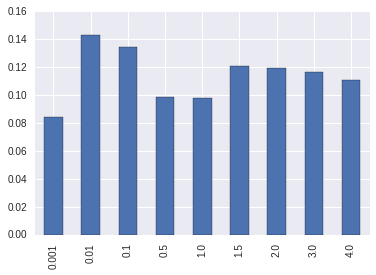

In [399]:
_sims_varA1_homog_plfits_Ds = {k: v.power_law.D for k,v in _sims_varA1_homog_plfits.items()}
_df = pd.DataFrame(_sims_varA1_homog_plfits_Ds.values(),
             index=_sims_varA1_homog_plfits_Ds.keys())[0]
_df.sort_index().plot(kind='bar')#,logy=True)

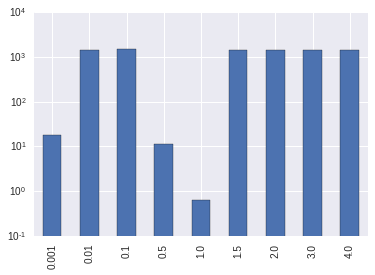

In [158]:
_sims_varA1_homog_plfits_lls = {k: v.power_law.loglikelihood for k,v in _sims_varA1_homog_plfits.items()}
_df = pd.DataFrame(_sims_varA1_homog_plfits_lls.values(),
             index=_sims_varA1_homog_plfits_lls.keys())[0]
(_df.sort_index()*-1).plot(kind='bar',logy=True)

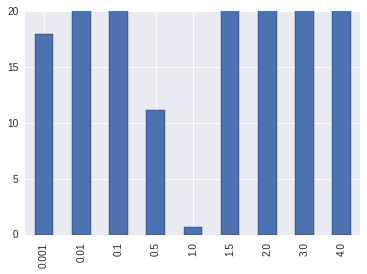

In [163]:
_sims_varA1_homog_plfits_lls = {k: v.power_law.loglikelihood for k,v in _sims_varA1_homog_plfits.items()}
_df = pd.DataFrame(_sims_varA1_homog_plfits_lls.values(),
             index=_sims_varA1_homog_plfits_lls.keys())[0]
(_df.sort_index()*-1).plot(kind='bar',ylim=[0,20])#,logy=True)

Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


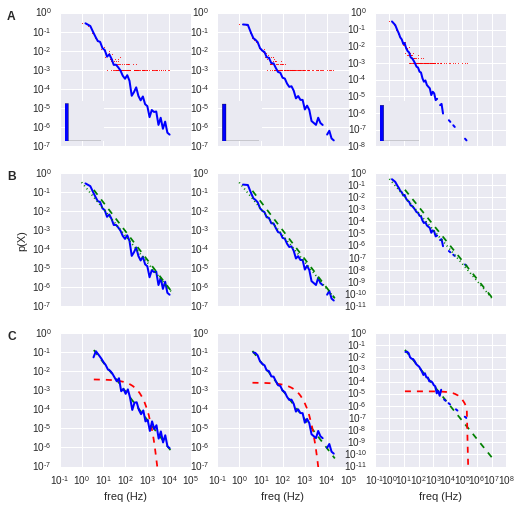

In [219]:
alldata = _sims_varA1_homog_tpdfs_cat


n_data = 3
n_graphs = 4
f = figure(figsize=(8,11))

data = alldata[A1s[0]].copy().values
data = data / data.min()
data_inst = 1
units = 'freq (Hz)'
plot_basics(data, data_inst, f, units)




data = alldata[A1s[3]].copy().values
data = data / data.min()
data_inst = 2
units = 'freq (Hz)'
plot_basics(data, data_inst, f, units)




data = alldata[A1s[6]].copy().values
data = data / data.min()
data_inst = 3
units = 'freq (Hz)'
plot_basics(data, data_inst, f, units)


Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


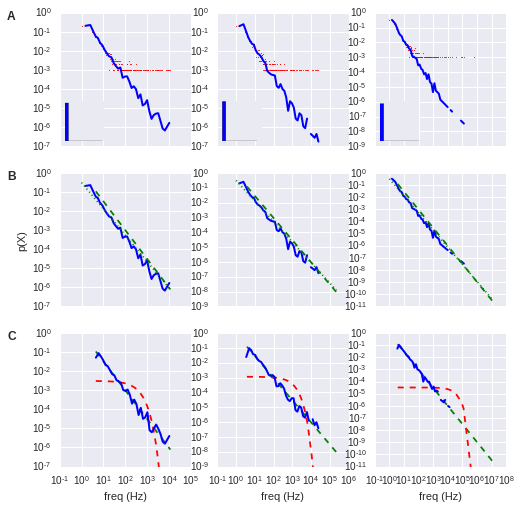

In [223]:
alldata = _sims_varA1_tpdfs_cat

n_data = 3
n_graphs = 4
f = figure(figsize=(8,11))

data = alldata[A1s[0]].copy().values
data = data / data.min()
data_inst = 1
units = 'freq (Hz)'
plot_basics(data, data_inst, f, units)




data = alldata[A1s[3]].copy().values
data = data / data.min()
data_inst = 2
units = 'freq (Hz)'
plot_basics(data, data_inst, f, units)




data = alldata[A1s[6]].copy().values
data = data / data.min()
data_inst = 3
units = 'freq (Hz)'
plot_basics(data, data_inst, f, units)


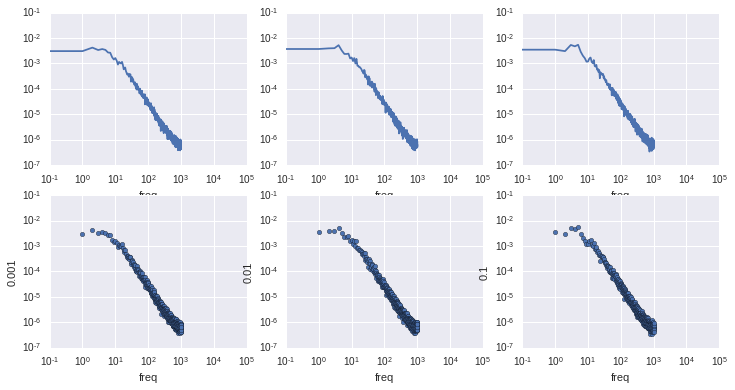

In [258]:

fig, ax = plt.subplots(ncols=3,nrows=2,figsize=(12,6))

ylims = [10E-8,10E-2]
xlims = [10E-2,10E4]

c = A1s[0]
alldata[c].plot(kind='line', 
                x='freq', y=c,logy=True,logx=True,
                xlim=xlims, ylim=ylims,ax=ax[0][0])
alldata[c].reset_index().plot(kind='scatter', 
                     x='freq', y=c,logy=True,logx=True,
                     xlim=xlims, ylim=ylims,ax=ax[1][0])

c = A1s[1]
alldata[c].plot(kind='line', 
                x='freq', y=c,logy=True,logx=True,
                xlim=xlims, ylim=ylims,ax=ax[0][1])
alldata[c].reset_index().plot(kind='scatter', 
                     x='freq', y=c,logy=True,logx=True,
                     xlim=xlims, ylim=ylims,ax=ax[1][1])


c = A1s[2]
alldata[c].plot(kind='line', 
                x='freq', y=c,logy=True,logx=True,
                xlim=xlims, ylim=ylims,ax=ax[0][2])
alldata[c].reset_index().plot(kind='scatter', 
                     x='freq', y=c,logy=True,logx=True,
                     xlim=xlims, ylim=ylims,ax=ax[1][2])


PSE as a function of A1 and sigma1. 



In [539]:
# Increasing sigma reduces alpha spectral peak
A1s = 10**r_[-0.001:1:10j]
sigma1s = 10**r_[-0.001:1:10j]
combs = list(itertools.product(A1s,sigma1s))

_sims_pse = {}
_sims_pse_tpdfs = {}
_sims_pse_fits = {}
_sims_pse_fit_Ds = {}
for (A1,sigma1) in combs:
    
  s = NF2pnt1D(sigma1=sigma1,A1=A1) 
  s.run()
  s.compute_totalpow()
  s.compute_totalpow_per()

  _sims_pse[A1,sigma1] = s
  _sims_pse_tpdfs[A1,sigma1] = s.df_TotalPow
    
  data = np.squeeze(s.df_TotalPow.values.copy())
  data = data / data.min()
    
  _fit = powerlaw.Fit(data, discrete=True,xmin=1)
  _sims_pse_fits[A1,sigma1] = _fit
    
  _sims_pse_fit_Ds[A1,sigma1] = _fit.power_law.D    
        
clear_output()

In [540]:
# Now plot heatmap of Ds...

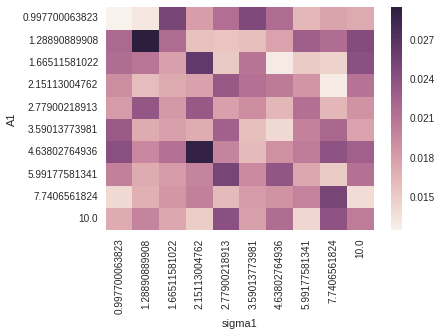

In [480]:
# this was the map with xmin not fixed...
_arr1 = np.array(_sims_pse_fit_Ds.keys())        
_arr2 = np.array(_sims_pse_fit_Ds.values())[:,np.newaxis]
_arr12 = np.concatenate([_arr1,_arr2],axis=1)
_df = pd.DataFrame(_arr12,columns=['A1', 'sigma1', 'D'])
sns.heatmap(_df.set_index(['A1', 'sigma1'])['D'].unstack())

In [542]:
# that was for the mixed conn
# now same for the homog conn only

In [543]:
# Increasing sigma reduces alpha spectral peak
A1s = 10**r_[-0.001:1:10j]
sigma1s = 10**r_[-0.001:1:10j]
combs = list(itertools.product(A1s,sigma1s))

_sims_homogconn_pse = {}
_sims_homogconn_pse_tpdfs = {}
_sims_homogconn_pse_fits = {}
_sims_homogconn_pse_fit_Ds = {}
for (A1,sigma1) in combs:
    
  s = NF2pnt1D(sigma1=sigma1,A1=A1,c12=0,c21=0)
  s.run()
  s.compute_totalpow()
  s.compute_totalpow_per()

  _sims_homogconn_pse[A1,sigma1] = s
  _sims_homogconn_pse_tpdfs[A1,sigma1] = s.df_TotalPow
    
  data = np.squeeze(s.df_TotalPow.values.copy())
  data = data / data.min()
    
  _fit = powerlaw.Fit(data, discrete=True,xmin=1)
  _sims_homogconn_pse_fits[A1,sigma1] = _fit
    
  _sims_homogconn_pse_fit_Ds[A1,sigma1] = _fit.power_law.D    
        
clear_output()



_arr1 = np.array(_sims_homogconn_pse_fit_Ds.keys())        
_arr2 = np.array(_sims_homogconn_pse_fit_Ds.values())[:,np.newaxis]
_arr12 = np.concatenate([_arr1,_arr2],axis=1)
_df = pd.DataFrame(_arr12,columns=['A1', 'sigma1', 'D'])
sns.heatmap(_df.set_index(['A1', 'sigma1'])['D'].unstack())

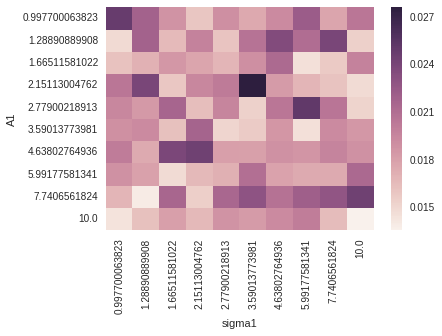

In [481]:
# this was the map with xmin not fixed...
_arr1 = np.array(_sims_homogconn_pse_fit_Ds.keys())        
_arr2 = np.array(_sims_homogconn_pse_fit_Ds.values())[:,np.newaxis]
_arr12 = np.concatenate([_arr1,_arr2],axis=1)
_df = pd.DataFrame(_arr12,columns=['A1', 'sigma1', 'D'])
sns.heatmap(_df.set_index(['A1', 'sigma1'])['D'].unstack())

In [441]:
# now plot heatmap of Ds

In [204]:
"""
# <!-- collapse=True -->


figf = outdir + '/pics/surface_sim_alphapeak_params_plfits.png'


# Fit power law function
# --------------------



fig, ax = plt.subplots(nrows=1,ncols=6,figsize=(12,3))

nodes = [node10idx1to5[0],node20idx1to5[0],node30idx1to5[0],
         node40idx1to5[0],node50idx1to5[0],node60idx1to5[0]]
#nodes.remove(18)
#nodes.remove(19)

for node_it,node in enumerate(nodes):
    
  a = ax.ravel()[node_it]
    
  fit = powerlaw.Fit(df_fs[node].values,discrete=True)
  fit.distribution_compare('power_law', 'lognormal')
  fit.plot_ccdf(linewidth=3, label='Empirical Data',ax=a)
  fit.power_law.plot_ccdf(ax=a, color='r', linestyle='--', label='Power law fit')
  fit.lognormal.plot_ccdf(ax=a, color='g', linestyle='--', label='Lognormal fit')    
    
  a.set_xlim([0,df_fs.index.max()])
  a.set_ylim([10E-4,10E0])

    
plt.tight_layout()



plt.tight_layout()
""";

Matlab code

## 2D neural fields

***...work in progress***

## TVB models

In [ ]:
L= sim_hetconn.L
dx = sim_hetconn.dx
T = sim_hetconn.T
dt = sim_hetconn.dt
vel = sim_hetconn.vel
A1 = sim_hetconn.A1
sigma1 = sim_hetconn.sigma1
c12 = sim_hetconn.c12
c21 = sim_hetconn.c21
  

In [238]:
sim_hetconn.dt

In [235]:
dt

In [209]:
    # 1. Define space and time
  
  
    # space
x=r_[0:L+dx:dx] #x=r_[0:L:dx] 
y = r_[0:L+dx:dx]#y=r_[0:L:dx]
x0=r_[-L/2.:(L/2.)+dx:dx]#x0=r_[-L/2:L/2:dx];

IDIM = int(L/dx + 1);#		% number of grid points

print('Number IDIM of spatial grid points is %g \n' %IDIM)

  

# time
t = r_[0:T+dt:dt] #t=r_[0:T:dt];
ndim = int(T/dt + 1);#% number of time points

print('Number ndim of time points is %g \n' %ndim )


maxdelay=L/vel; #          % maximal delay possible

print('Maximal time delay is %g \n'  %maxdelay)


IMAX = int(round(maxdelay/dt)+1) #		    % max number of delay time points

print('Max number IMAX of delay time points is %g \n' %IMAX)

    

# 2. Define connectivity
  
    

#% connectivity matrix
[x,y] = np.meshgrid(x,y);

  

#% homogeneous connectivity  
    
w = A1*np.exp(-abs(x-y)/sigma1)/sigma1/2.;    #   % Homogeneous connectivity IDIM x IDIM
        
        

# heterogeneous connectivity
    

#w[6:7,IDIM-7:IDIM-6]=5;              % Heterogeneous component
#w[IDIM-7:IDIM-6,6:7]=-5; 


## JG ADD + mode - long-range connectivity weights    
w[5:7,IDIM-7:IDIM-5]=c12;           #   % Heterogeneous component

w[IDIM-7:IDIM-5,5:7]=c21
  

    # space-time matrix distributing connecitvity and time delay
    
wsize=w.shape# np.shape(w) # size(w);
    

ww=np.zeros([IMAX,wsize[0],wsize[1]]);   #' % creation of space-time matrix distributing
itau=np.round(1.+abs(x-y)/dt/vel).astype(int);       #                % connectivity and time delay itau
for ix in r_[1:IDIM].astype(int):#r_[1:IDIM-1:1]:
    for iy in r_[1:IDIM].astype(int):
        ww[itau[ix,iy],ix,iy]=w[ix,iy];

        

#x=x[0,:].T
#y=y[0,:].T 

#(1,:)';            % space vectors are now again IDIM x 1

  
# 3. Initialize neural field values

Number IDIM of spatial grid points is 31 

Number ndim of time points is 2001 

Maximal time delay is 3 

Max number IMAX of delay time points is 121 



In [210]:
[xmesh,ymesh] = np.meshgrid(x,y);

itau=np.round(1.+abs(xmesh-ymesh)/dt/vel).astype(int);   

In [211]:
itau.shape

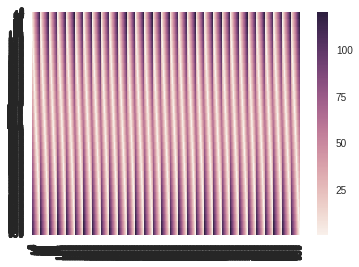

In [206]:
sns.heatmap(itau)

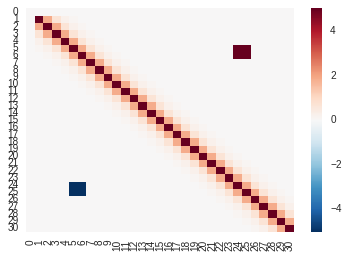

In [197]:
sns.heatmap(sim_mixedconn.ww.sum(axis=0))

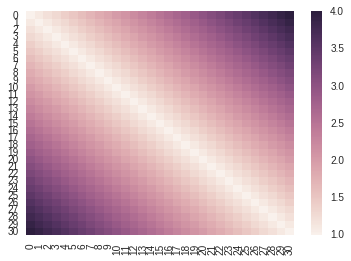

In [216]:
sns.heatmap(sim_hetconn.homog_dist)

In [ ]:
    ## JG ADD + mode - long-range connectivity weights    
    w[5:7,IDIM-7:IDIM-5]=c12;           #   % Heterogeneous component
    w[IDIM-7:IDIM-5,5:7]=c21
  
    # space-time matrix distributing connecitvity and time delay
    wsize=w.shape# np.shape(w) # size(w);
    ww=np.zeros([IMAX,wsize[0],wsize[1]]);   #' % creation of space-time matrix distributing
    itau=np.round(1.+abs(x-y)/dt/vel).astype(int);       #                % connectivity and time delay itau
    for ix in r_[1:IDIM].astype(int):#r_[1:IDIM-1:1]:
      for iy in r_[1:IDIM].astype(int):
        ww[itau[ix,iy],ix,iy]=w[ix,iy];


In [ ]:
itau=np.round(1.+abs(x-y)/dt/vel).astype(int);       #                % connectivity and time delay itau
    

In [170]:
sim_hetconn.y

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.])

In [167]:
sim_hetconn.x - sim_hetconn.y

array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ,
        1.1,  1.2,  1.3,  1.4,  1.5,  1.6,  1.7,  1.8,  1.9,  2. ,  2.1,
        2.2,  2.3,  2.4,  2.5,  2.6,  2.7,  2.8,  2.9,  3. ])

In [163]:
sim_hetconn.ww.shape

In [164]:
sim_hetconn.dt

In [165]:
sim_hetconn.vel

In [ ]:
sim_hetconn.

### Network version (no surface connectivity)

In [157]:
df_homconn_zz = pd.DataFrame(sim_homconn.zz.T)
df_hetconn_zz = pd.DataFrame(sim_hetconn.zz.T)
df_mixedconn_zz = pd.DataFrame(sim_mixedconn.zz.T)

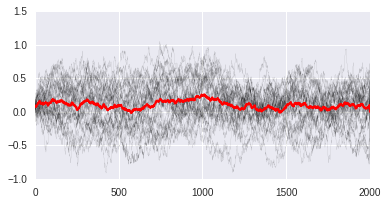

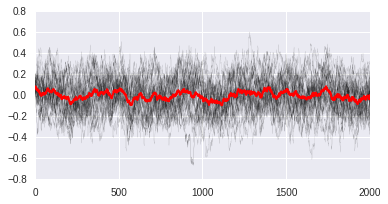

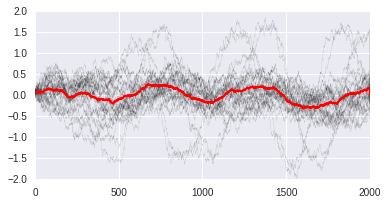

In [158]:
df_homconn_zz.plot(figsize=(6,3),c='k', linewidth=0.1,legend=False,alpha=0.5);
df_homconn_zz.mean(axis=1).plot(c='r', legend=False,linewidth=2.);

df_hetconn_zz.plot(figsize=(6,3),c='k', linewidth=0.1,legend=False,alpha=0.5);
df_hetconn_zz.mean(axis=1).plot(c='r', legend=False,linewidth=2.);

df_mixedconn_zz.plot(figsize=(6,3),c='k', linewidth=0.1,legend=False,alpha=0.5);
df_mixedconn_zz.mean(axis=1).plot(c='r', legend=False,linewidth=2.);

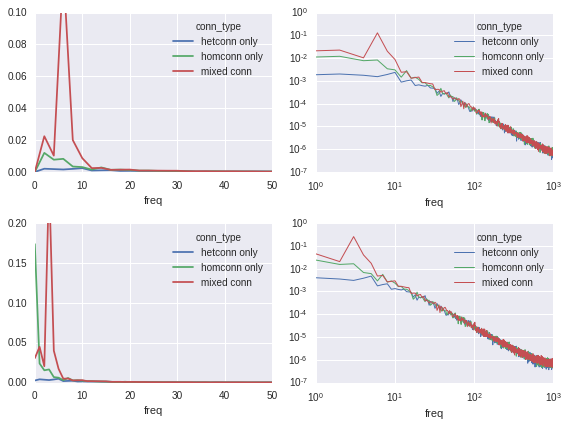

In [126]:
df_tp = pd.concat({'hetconn only': sim_hetconn.df_TotalPow.copy(),
                'homconn only': sim_homconn.df_TotalPow.copy(),
                'mixed conn': sim_mixedconn.df_TotalPow.copy()})
df_tp.index.names = ['conn_type', 'freq']
df_tp = df_tp.unstack('conn_type')
df_tp = df_tp[0]


df_tpp = pd.concat({'hetconn only': sim_hetconn.df_TotalPow_Per.copy(),
                'homconn only': sim_homconn.df_TotalPow_Per.copy(),
                'mixed conn': sim_mixedconn.df_TotalPow_Per.copy()})
df_tpp.index.names = ['conn_type', 'freq']
df_tpp = df_tpp.unstack('conn_type')
df_tpp = df_tpp[0]


fig, ax = plt.subplots(ncols=2,nrows=2,figsize=(8,6))

df_tpp.plot(xlim=[0,50],ylim=[0,0.1],ax=ax[0][0])
df_tpp.plot(ax=ax[0][1],logx=True,logy=True,
        ylim=[10E-8,10E-1],xlim=[10E-1,10E2],linewidth=1.)

df_tp.plot(xlim=[0,50],ylim=[0,0.2],ax=ax[1][0])
df_tp.plot(ax=ax[1][1],logx=True,logy=True,
        ylim=[10E-8,10E-1],xlim=[10E-1,10E2],linewidth=1.)

plt.tight_layout()

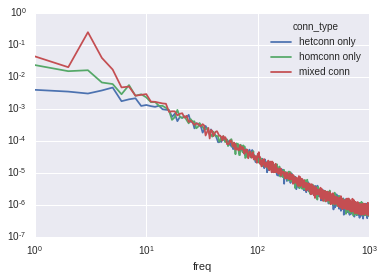

In [129]:
df_tp.plot(logx=True,logy=True)

In [ ]:
sns.heatmap(sim_hetconn.w)
sns.heatmap(sim_homconn.w)
sns.heatmap(sim_mixedconn.w)

In [64]:
from scipy.signal import periodogram

In [ ]:
# match noise to 1D sim      noise=5.*(np.random.rand(IDIM,1)-0.5);


In [239]:
integrators.HeunStochastic()

HeunStochastic(dt=0.01220703125, clamped_state_variable_indices=None, clamped_state_variable_values=None, noise=Additive(ntau, random_stream, nsig))

In [233]:
tvb_hetconn = connectivity.Connectivity()
tvb_hetconn.generate_surrogate_connectivity(sim_hetconn.w.shape[0],motif='linear')
tvb_hetconn.weights = sim_hetconn.w
tvb_hetconn.tract_lengths = sim_hetconn.homog_dist
tvb_hetconn.speed = sim_hetconn.vel
tvb_hetconn.configure()


tvb_homconn = connectivity.Connectivity()
tvb_homconn.generate_surrogate_connectivity(sim_homconn.w.shape[0],motif='linear')
tvb_homconn.weights = sim_homconn.w
tvb_homconn.tract_lengths = sim_homconn.homog_dist
tvb_homconn.speed = sim_homconn.vel
tvb_homconn.configure()


tvb_mixedconn = connectivity.Connectivity()
tvb_mixedconn.generate_surrogate_connectivity(sim_mixedconn.w.shape[0],motif='linear')
tvb_mixedconn.weights = sim_mixedconn.w
tvb_mixedconn.tract_lengths = sim_mixedconn.homog_dist
tvb_mixedconn.speed = sim_mixedconn.vel
tvb_mixedconn.configure()



# Specify model and run sim
# --------------------------

# objective: give params correponding to something like this
#u = u + dt*( -u + out2 + noise + s.T*block(it,50*dt,100*dt)*np.sin(np.pi*(it-50*dt)/25./dt)); 
NF2pnt1D_g2do_params = dict(f = 0.,e = 0., g = -1,#d =1.,tau = 1.
                            alpha = 0., gamma = 1., c = 0.,b= 0,
                            beta = 0, a = 0.,I=2.)

# \dot{V} &= d \, \tau (-f V^3 + e V^2 + g V + \alpha W + \gamma I), \\
# \dot{W} &= \dfrac{d}{\tau}\,\,(c V^2 + b V - \beta W + a),

df_tavg_homconn = run_tvb_sim(NF2pnt1D_g2do_params,conn=tvb_homconn, dt=dt,tavg_per=dt,nsig=5.)# 1E-5)# 5.)
_hz,_dat = periodogram(df_tavg_homconn.values.T,fs=1.0)
df_psd_homconn = pd.DataFrame(_dat.T,index=_hz)

df_tavg_hetconn = run_tvb_sim(NF2pnt1D_g2do_params,conn=tvb_hetconn,dt=dt,tavg_per=dt,nsig=5.,)
_hz,_dat = periodogram(df_tavg_hetconn.values.T,fs=1.0)
df_psd_hetconn = pd.DataFrame(_dat.T,index=_hz)

df_tavg_mixedconn = run_tvb_sim(NF2pnt1D_g2do_params,conn=tvb_mixedconn,dt=dt,tavg_per=dt,nsig=5.)
_hz,_dat = periodogram(df_tavg_mixedconn.values.T,fs=1.0)
df_psd_mixedconn = pd.DataFrame(_dat.T,index=_hz)

In [243]:
models.Generic2dOscillator()

Generic2dOscillator(a=[-2.], tau=[ 1.], c=[ 0.], noise=Noise(ntau, random_stream), e=[ 3.], d=[ 0.02], g=[ 0.], f=[ 1.], I=[ 0.], state_variable_range={'W': array([-6.,  6.]), 'V': array([-2.,  4.])}, beta=[ 1.], b=[-10.], variables_of_interest=['V'], alpha=[ 1.], gamma=[ 1.])

In [ ]:
# spiegler params
gamma_sp = -1.#0.01 # just under critical point (note is converted to minus below) #1.21
epsilon_sp =  12.3083
eta_sp = (1/1000.) * 76.74   

sp_g2do_params = dict(d = eta_sp,  tau = 1.,f = 1.,
              e = 0., g = -gamma_sp,alpha = 1., 
              gamma = 1., c = 0., b= -epsilon_sp,
              beta = 0,  a = 0.)

In [286]:
gamma_sp = 1.21
epsilon_sp =  12.3083

# is this the correct? 
# - units in Spiegler are S^-1. 
# - default value for g2do d is 0.02
# - so this gives 0.07674
eta_sp = (1/1000.) * 76.74    #eta_sp = 76.74 # 1. # 76.74 ##1. # 76.74 # 1.



sp_g2do_params = dict(d = eta_sp,
                      tau = 1.,
                      f = 1.,
                      e = 0., 
                      g = -gamma_sp,
                      alpha = 1., 
                      gamma = 1., 
                      c = 0.,
                      b= -epsilon_sp, # should not be negative? LOOKS LIKE IT AL COMES DOWN TO THIS PARAM
                      beta = 0,
                      a = 0.)


df_tavg_homconn = run_tvb_sim(sp_g2do_params,
                              conn=connectivity.Connectivity(load_default=True),nsig=100000.,
                              )#tvb_homconn,nsig=50.)#, dt=dt,tavg_per=dt,nsig=5.)# 1E-5)# 5.)
_hz,_dat = periodogram(df_tavg_homconn.values.T,fs=1.0)
df_psd_homconn = pd.DataFrame(_dat.T,index=_hz)

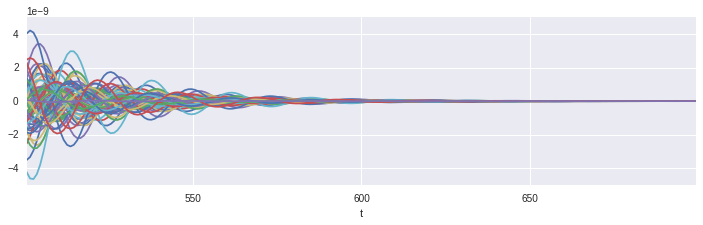

In [290]:
df_tavg_homconn.loc[500:700].plot(legend=False,figsize=(12,3))

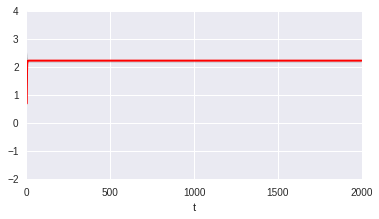

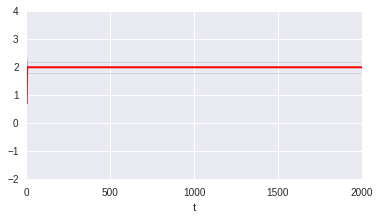

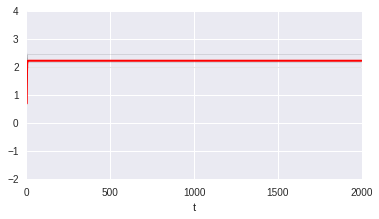

In [226]:
df_tavg_homconn.plot(figsize=(6,3),c='k', linewidth=0.1,legend=False,alpha=0.5);
df_tavg_homconn.mean(axis=1).plot(c='r', legend=False,linewidth=2.);

df_tavg_hetconn.plot(figsize=(6,3),c='k', linewidth=0.1,legend=False,alpha=0.5);
df_tavg_hetconn.mean(axis=1).plot(c='r', legend=False,linewidth=2.);

df_tavg_mixedconn.plot(figsize=(6,3),c='k', linewidth=0.1,legend=False,alpha=0.5);
df_tavg_mixedconn.mean(axis=1).plot(c='r', legend=False,linewidth=2.);

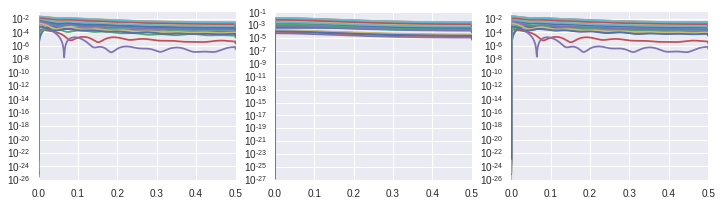

In [124]:
fig, ax = plt.subplots(ncols=3,figsize=(12,3))

df_psd_homconn.plot(legend=False,ax=ax[0],logy=True)
df_psd_hetconn.plot(legend=False,ax=ax[1],logy=True)                              
df_psd_mixedconn.plot(legend=False,ax=ax[2],logy=True)

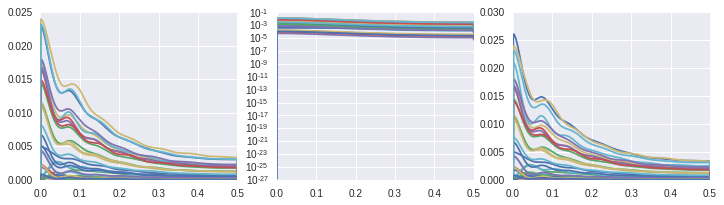

In [125]:
fig, ax = plt.subplots(ncols=3,figsize=(12,3))

df_psd_homconn.plot(legend=False,ax=ax[0],logy=False)
df_psd_hetconn.plot(legend=False,ax=ax[1],logy=True)                              
df_psd_mixedconn.plot(legend=False,ax=ax[2],logy=False)

In [ ]:
# Compute power spectrum
# ---------------------------------------
sampling_interval= np.unique(np.diff(df_tavg.index.values))[0] / 1000.
df_fs,df_mts,S = compute_nitime_ps(df_tavg.values.T,
                                   df_tavg.index[:,np.newaxis],
                                   sampling_interval)





fig, ax = plt.subplots()

df_mts.plot(logx=True,logy=True,ax=ax,legend=False,linewidth=0.5,alpha=0.5)
df_mts.mean(axis=1).plot(logx=True,logy=True,ax=ax,c='r',legend=False)

ax.plot(df_mts.index,1/(df_mts.index**2), '--', c='k', alpha=0.5)

In [ ]:
    
    out1 = np.zeros([IDIM,IDIM])
    
    for it in r_[0:T:dt]:
      for ix in r_[0:IDIM]: #r_[1:IDIM+1:1]:
        out1[ix,:]=np.sum(ww[:,:,ix]*np.arctan(uold).T,axis=0);
                       
      out2=np.sum(out1.T*dx,axis=0).T[:,np.newaxis]
      noise=5.*(np.random.rand(IDIM,1)-0.5);
            
      u = u + dt*( -u + out2 + noise + s.T*block(it,50*dt,100*dt)*np.sin(np.pi*(it-50*dt)/25./dt)); 
            
      #%        u = u + dt*( -u + 0.5*out2 + s'*block(it,10*dt,20*dt) );   
      #%  u(1)=0.5*(u(1)+u(IDIM));u(IDIM)=u(1);		        % periodic boundary conditions
      u[0]=u[1];
      u[IDIM-1]=u[IDIM-2];		                  #  % zero flux boundary conditions
     
      pp = np.ones(u.shape)*np.sum(u)*dx/L;               #    % spatial mean of the neural field
   
            
      for i in r_[IMAX-1:0:-1]:    #     % updating of delay vector 
        uold[:,i] = uold[:,i-1];                   #     % neural field
        pold[:,i] = pold[:,i-1];                 #       % spatial average 

      uold[:,0]=u.T
      pold[:,0]=pp.T
      k=k+1;
      zz[:,k][:,np.newaxis] = u;                          #     % zz will be the space-time plot


        


### 2 point connection in TVB

In [18]:
# just zero out all but 2 entries in the connectivity matrix...
# get purely homogeneous by setting long range conn - 0 for the retained connection also

# get purely heterogeneous with region-level sim

In [19]:
from tvb.datatypes.region_mapping_data import RegionMappingData
from tvb.datatypes.cortex import Cortex
from nilearn.plotting import plot_surf

In [20]:
origctx = cortex.Cortex(load_default=True)
origctx.configure()

origconn = connectivity.Connectivity(load_default=True)
origconn.configure()

lA1_nodenum = 38
rA1_nodenum = 0
rA1lA1_nodenums = np.array([rA1_nodenum,lA1_nodenum])

#newmat = np.zeros_like(conn.weights)
#newmat[rA1_nodenum,lA1_nodenum] = 3
#newmat[lA1_nodenum,rA1_nodenum] = 3

newmat = np.array([[0,1],[1,0]])
newconn = connectivity.Connectivity()
newconn.weights = newmat
newconn.region_labels = origconn.region_labels[rA1lA1_nodenums]
newconn.centres = origconn.centres[rA1lA1_nodenums]
newconn.cortical = origconn.cortical[rA1lA1_nodenums]
newconn.hemispheres = origconn.hemispheres[rA1lA1_nodenums]
newconn.tract_lengths = origconn.tract_lengths[rA1lA1_nodenums,:][:,rA1lA1_nodenums]
newconn.configure()

lA1_rmidxs_orig = np.nonzero(origctx.region_mapping==lA1_nodenum)[0]
rA1_rmidxs_orig = np.nonzero(origctx.region_mapping==rA1_nodenum)[0]


alltris_in_lA1_idxs_orig = []
alltris_in_rA1_idxs_orig = []

for l_it,l in enumerate(origctx.triangles):
  if (l[0] in lA1_rmidxs_orig and l[1] in lA1_rmidxs_orig and l[2] in lA1_rmidxs_orig): 
    alltris_in_lA1_idxs_orig.append(l_it)
    
  if (l[0] in rA1_rmidxs_orig and l[1] in rA1_rmidxs_orig and l[2] in rA1_rmidxs_orig): 
    alltris_in_rA1_idxs_orig.append(l_it)    
    
    
# Tests: these should error if any of the triangle values are not in the 'alltris' arrays 

assert len([l for l in origctx.triangles[alltris_in_lA1_idxs_orig].ravel() if l not in lA1_rmidxs_orig]) == 0
assert len([l for l in origctx.triangles[alltris_in_rA1_idxs_orig].ravel() if l not in rA1_rmidxs_orig]) == 0

In [21]:
newtris = origctx.triangles[alltris_in_rA1_idxs_orig+alltris_in_lA1_idxs_orig]
newrm = np.array([rA1_nodenum for r in rA1_rmidxs_orig] + [lA1_nodenum for l in lA1_rmidxs_orig])
newrm_v2 = newrm.copy()
newrm_v2[newrm==38] = 1

newvtxids_un = np.unique(newtris)
newvtcs = origctx.vertices[newvtxids_un]
newvtcs_key = {k: k_it for k_it,k in enumerate(newvtxids_un)}
newtris_renamed = np.array([[newvtcs_key[kk] for kk in k] for k in newtris])


new_vertex_triangles = [origctx.vertex_triangles[r] for r in newvtxids_un]


# test: newtris_renamed should pick out same array from newvtcs as newtris picks out from orig vtcs
assert len(np.nonzero((newvtcs[newtris_renamed].ravel() == origctx.vertices[newtris].ravel())==False)[0]) == 0


#ok now create the new cortex from these components

newctx = Cortex()
#newctx = cortex.CorticalSurface()
newctx.coupling_strength = numpy.array([2**-10])

newctx.vertices = newvtcs
newctx.triangles = newtris_renamed
#newctx.region_mapping_data = newrm
#setattr(newctx,'region_mapping', newrm)
tmprm = RegionMappingData()
tmprm.array_data = newrm_v2
newctx.region_mapping_data = tmprm
#newctx.vertex_triangles = new_vertex_triangles
#newctx.vertex_normals = origctx.vertex_normals[newvtxids_un]
newctx.configure()

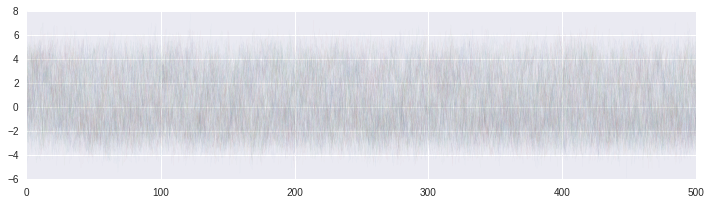

In [57]:
model = models.Generic2dOscillator()
solver = integrators.HeunStochastic()
cpl = coupling.Linear(a=0.1)
mons = (monitors.TemporalAverage(period=2**-2))


#Initialise Simulator -- Model, Connectivity, Integrator, Monitors, and surface.
sim = simulator.Simulator(model = model, connectivity = newconn,
                          coupling = cpl,
                          integrator = solver,monitors = mons,
                          surface = newctx)
sim.configure()

res = sim.run(simulation_length=500)

tavg_time,tavg_dat = res[0]
df_tavg = pd.DataFrame(np.squeeze(tavg_dat),index=tavg_time)


df_tavg.plot(legend=False,figsize=(12,3),linewidth=0.01)

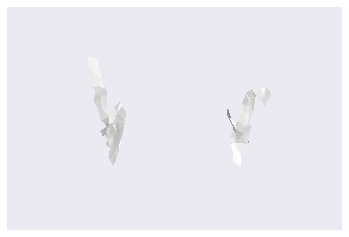

In [58]:
ax = plot_surf([newctx.vertices,newctx.triangles]);

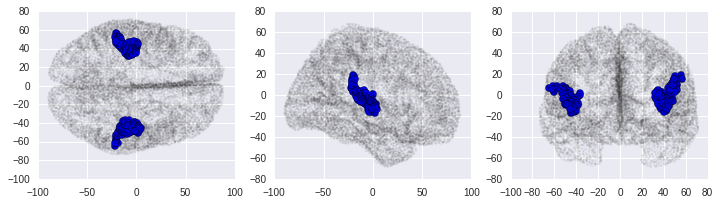

In [59]:
fig, ax =plt.subplots(ncols=3,figsize=(12,3))

x,y,z = newctx.vertices.T

ax[0].scatter(x,y,c='b',s=50)
ax[1].scatter(x,z,c='b',s=50)
ax[2].scatter(y,z,c='b',s=50)


x,y,z = origctx.vertices.T
ax[0].scatter(x,y,linewidth=0.0001,alpha=0.05,c='k',s=5)
ax[1].scatter(x,z,linewidth=0.001,alpha=0.05,c='k',s=5)
ax[2].scatter(y,z,linewidth=0.0001,alpha=0.05,c='k',s=5)

In [108]:
eta_sp

In [205]:
# SIM PARAMS THAT CHANGE 2D OSCILLATOR TO OCUPLED OSCILLATOR EQ IN JIRSA 2009: 
# dx_i/dt = -x_i + mu x_j(t-tau) 



#models.Generic2dOscillator??
#
#    .. math::
#                \dot{V} &= d \, \tau (-f V^3 + e V^2 + g V + \alpha W + \gamma I), \\
#                \dot{W} &= \dfrac{d}{\tau}\,\,(c V^2 + b V - \beta W + a),

#V params
 
f = 0
e = 0
    
g = -1  # ONLY USED PARAM...
    
alpha = 0
gamma = 0
    
# W params
c = 0
b = 0
beta = 0
a = 0


# Other params
d = 1  
tau = 1

I = 0

params = dict(d = d,tau=tau,f=f,e=e,g=g,alpha=alpha,
              gamma=gamma,c=c,b=b,beta=beta,a=a,I=I)
                
    

# So: we set all W params to zero
# ...and the nonlinear V params to zero
# ...and only keep the negative self feedback
# 

# Specify model and run sims
# --------------------------

lcs = [eval('2**-%s' %n) for n in range(0,10,3)]

#gamma_sp = 0. #1.21
#epsilon_sp =  1. #10.#12.3083
#eta_sp = (1/1000.) * 76.74    #eta_sp = 76.74 # 1. # 76.74 ##1. # 76.74 # 1.
#params = dict(d = eta_sp,tau = 1.,f = 1.,e = 0., g = -gamma_sp,
#              alpha = 1., gamma = 1., c = 0.,b= -epsilon_sp, 
#              beta = 0, a = 0.,I=2.0)



#dt = 0.1 # 2**-4# 0.1
n_step=20000

#gamma_sp = 0.1 #1.21
#epsilon_sp =  1. #10.#12.3083
#eta_sp = (1/1000.) * 76.74 
#params = dict(d = eta_sp,tau = 1.,f = 1.,e = 0., g = -gamma_sp,
#              alpha = 1., gamma = 1., c = 0.,b= -epsilon_sp, 
#              beta = 0, a = 0.,I=0)#.5)

lc = lcs[0]

test = run_tvb_sim(params,sim_type='surface',local_coupling_strength=lc,
                                     surf=newctx,conn=newconn,
                                     solver_type='det',lca=1.)


df_fs,df_mts,S = compute_nitime_ps(test.values.T,
                                   test.index[:,np.newaxis],
                                   sampling_interval)
#df_fs.columns = all_idx1to5s  
#df_mts.columns = all_idx1to5s    
    


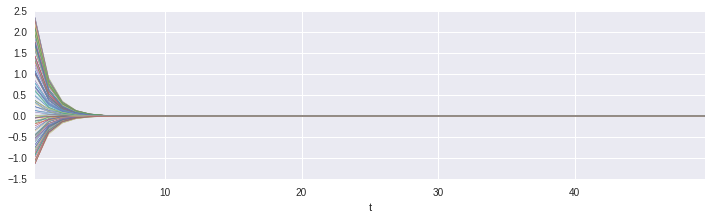

In [206]:
test.ix[:50].plot(legend=False,figsize=(12,3),linewidth=0.5)

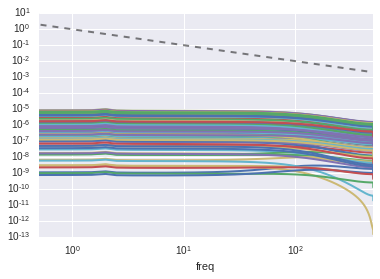

In [207]:
fig, ax = plt.subplots()

df = df_mts#test.mean(axis=1)#ax=ax)
doleg=False
df.plot(logx=True,logy=True,linewidth=2,ax=ax,legend=doleg)
    
linedat = 1/(df.index.values**2)
ax.plot(df.index**2,linedat, '--', c='k', linewidth=2,alpha=0.5)



In [193]:

linedat = 1/(df.index.values**2)
ax.plot(df.index,linedat, '--', c='k', linewidth=2,alpha=0.5)

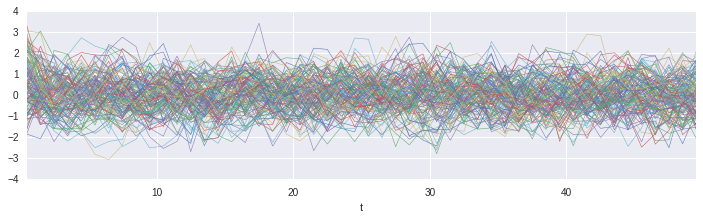

In [187]:
test.ix[:50].plot(legend=False,figsize=(12,3),linewidth=0.5)

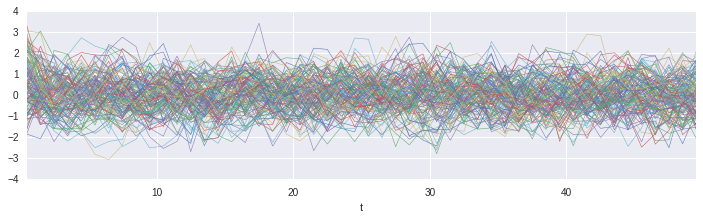

In [186]:
test.ix[:50].plot(legend=False,figsize=(12,3),linewidth=0.5)

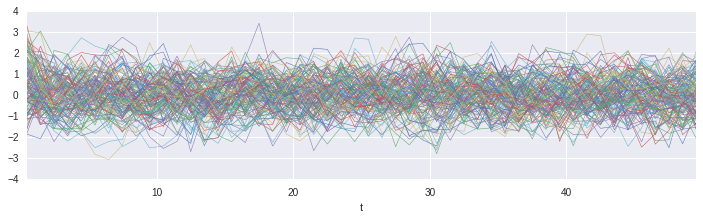

In [184]:
test.ix[:50].plot(legend=False,figsize=(12,3),linewidth=0.5)

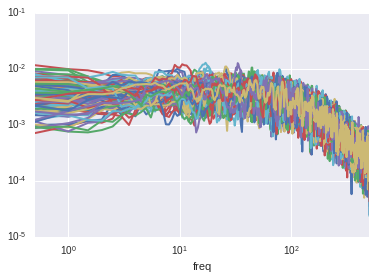

In [175]:
fig, ax = plt.subplots()

df = df_mts#test.mean(axis=1)#ax=ax)

doleg=False

df.plot(logx=True,logy=True,linewidth=2,ax=ax,legend=doleg)
    

In [ ]:
test.plot(legemd=False)

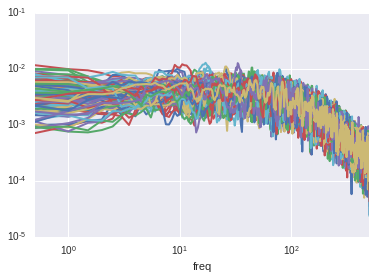

In [164]:
fig, ax = plt.subplots()

df = df_mts#test.mean(axis=1)#ax=ax)

doleg=False

df.plot(logx=True,logy=True,linewidth=2,ax=ax,legend=doleg)
    

In [165]:
linedat = 1/(df.index.values**2)
ax.plot(df.index,linedat, '--', c='k', linewidth=2,alpha=0.5)

In [ ]:
test.plot(legend=False)

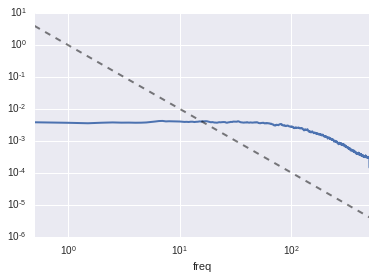

In [167]:
fig, ax = plt.subplots()

df = df_mts.mean(axis=1)

df.plot(logx=True,logy=True,linewidth=2,ax=ax,legend=doleg)
    
linedat = 1/(df.index.values**2)
ax.plot(df.index,linedat, '--', c='k', linewidth=2,alpha=0.5)

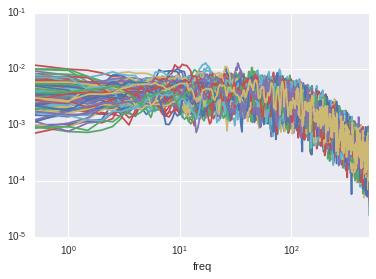

In [173]:
df_mts.plot(legend=False,logx=True,logy=True)

In [148]:
# Specify model and run sims
# --------------------------

lcs = [eval('2**-%s' %n) for n in range(0,10,3)]

#gamma_sp = 0. #1.21
#epsilon_sp =  1. #10.#12.3083
#eta_sp = (1/1000.) * 76.74    #eta_sp = 76.74 # 1. # 76.74 ##1. # 76.74 # 1.
#params = dict(d = eta_sp,tau = 1.,f = 1.,e = 0., g = -gamma_sp,
#              alpha = 1., gamma = 1., c = 0.,b= -epsilon_sp, 
#              beta = 0, a = 0.,I=2.0)



dt = 0.1 # 2**-4# 0.1
n_step=20000

gamma_sp = 0.1 #1.21
epsilon_sp =  1. #10.#12.3083
eta_sp = (1/1000.) * 76.74 
params = dict(d = eta_sp,tau = 1.,f = 1.,e = 0., g = -gamma_sp,
              alpha = 1., gamma = 1., c = 0.,b= -epsilon_sp, 
              beta = 0, a = 0.,I=0)#.5)

lc = lcs[0]

test = run_tvb_sim(params,sim_type='surface',local_coupling_strength=lc,
                                     surf=newctx,conn=newconn,
                                     solver_type='stoch',lca=0.5)


df_fs,df_mts,S = compute_nitime_ps(test.values.T,
                                   test.index[:,np.newaxis],
                                   sampling_interval)
#df_fs.columns = all_idx1to5s  
#df_mts.columns = all_idx1to5s    
    


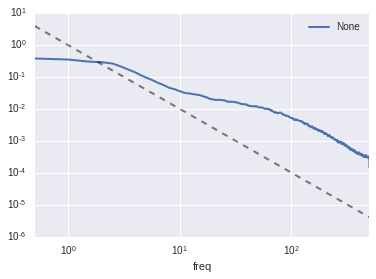

In [149]:
fig, ax = plt.subplots()

df = df_mts.mean(axis=1)

df.plot(logx=True,logy=True,linewidth=2,ax=ax,legend=doleg)
    
linedat = 1/(df.index.values**2)
ax.plot(df.index,linedat, '--', c='k', linewidth=2,alpha=0.5)

In [144]:
run_tvb_sim??

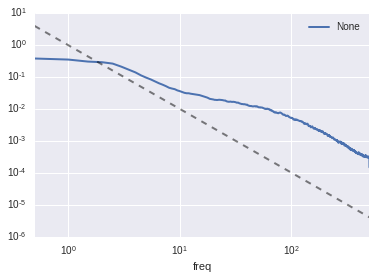

In [143]:
fig, ax = plt.subplots()

df = df_mts.mean(axis=1)

df.plot(logx=True,logy=True,linewidth=2,ax=ax,legend=doleg)
    
linedat = 1/(df.index.values**2)
ax.plot(df.index,linedat, '--', c='k', linewidth=2,alpha=0.5)

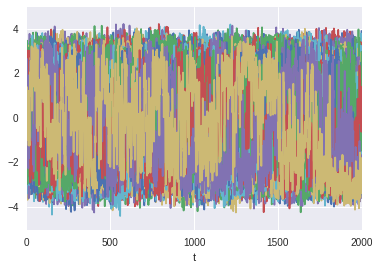

In [135]:
test.plot(legend=False)

In [141]:
newconn.weights

array([[0, 1],
       [1, 0]])

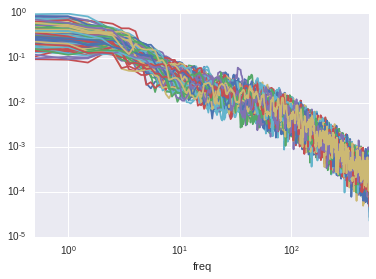

In [138]:


df_mts.plot(legend=False,logx=True,logy=True)

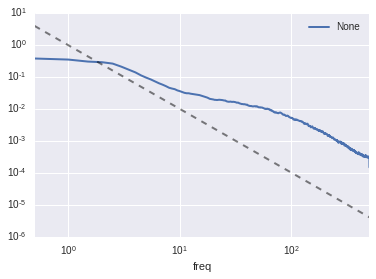

In [139]:
fig, ax = plt.subplots()

df = df_mts.mean(axis=1)

df.plot(logx=True,logy=True,linewidth=2,ax=ax,legend=doleg)
    
linedat = 1/(df.index.values**2)
ax.plot(df.index,linedat, '--', c='k', linewidth=2,alpha=0.5)

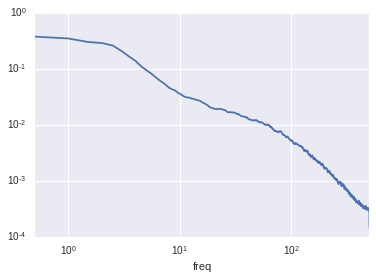

In [137]:
df_mts.mean(axis=1).plot(legend=False,logx=True,logy=True)

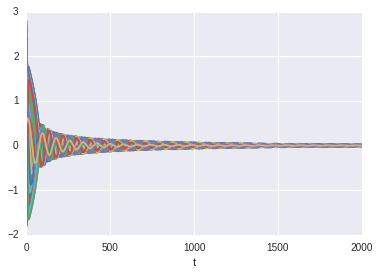

In [128]:
test.plot(legend=False)

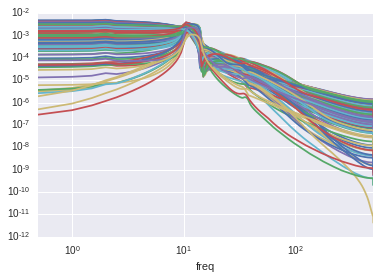

In [131]:
df_mts.plot(legend=False,logx=True,logy=True)

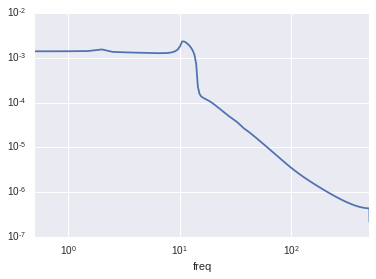

In [132]:
df_mts.mean(axis=1).plot(legend=False,logx=True,logy=True)

In [119]:
df_fs,df_mts,S = compute_nitime_ps(test.values.T,
                                   test.index[:,np.newaxis],
                                    sampling_interval)
#df_fs.columns = all_idx1to5s  
#df_mts.columns = all_idx1to5s    
    
df_fs_lcs[k] = df_fs
df_mts_lcs[k] = df_mts
    

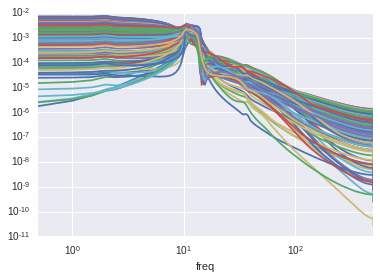

In [124]:
df_mts_lcs[k].plot(legend=False,logx=True,logy=True)

In [113]:
# Specify model and run sims
# --------------------------

lcs = [eval('2**-%s' %n) for n in range(0,10,3)]

gamma_sp = 0. #1.21
epsilon_sp =  1. #10.#12.3083
eta_sp = (1/1000.) * 76.74    #eta_sp = 76.74 # 1. # 76.74 ##1. # 76.74 # 1.
params = dict(d = eta_sp,tau = 1.,f = 1.,e = 0., g = -gamma_sp,
              alpha = 1., gamma = 1., c = 0.,b= -epsilon_sp, 
              beta = 0, a = 0.,I=2.0)

gamma_sp = 0.1 #1.21

In [114]:
df_newctx_tavg_lcs = {lc: run_tvb_sim(params,sim_type='surface',local_coupling_strength=lc,
                                     surf=newctx,conn=newconn)
                     for lc in lcs}

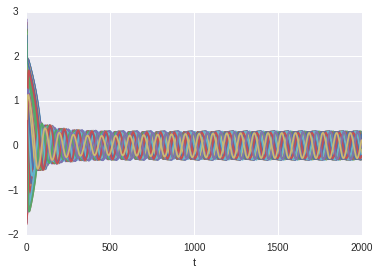

In [115]:
df_newctx_tavg_lcs[lcs[0]].plot(legend=False)

In [116]:
# Set coupl

In [117]:
# Compute power spectra
# ---------------------

sampling_interval= np.unique(np.diff(df_newctx_tavg_lcs.values()[0].index.values))[0] / 1000.

df_fs_lcs,df_mts_lcs = {},{}

for kv_it,(k,v) in enumerate(df_tavg_lcs.items()):

  df_fs,df_mts,S = compute_nitime_ps(v[all_idx1to5s].values.T,
                                     v.index[:,np.newaxis],
                                     sampling_interval)
  df_fs.columns = all_idx1to5s  
  df_mts.columns = all_idx1to5s    
    
  df_fs_lcs[k] = df_fs
  df_mts_lcs[k] = df_mts
    
# Concatenate into a singel pandas dataframe

df_newctx_mts_lcs_cat = pd.concat(df_mts_lcs)
df_newctx_mts_lcs_cat.index.names = ['lcs', 'freq']
df_newctx_mts_lcs_cat.columns.names = ['vtx_num']

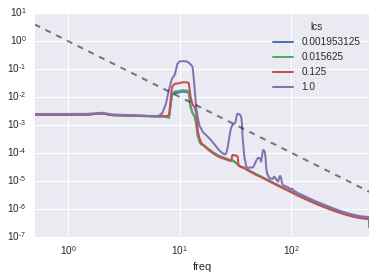

In [118]:
fig, ax = plt.subplots()

df = df_newctx_mts_lcs_cat.mean(axis=1).unstack('freq').T

df.plot(logx=True,logy=True,linewidth=2,ax=ax,legend=doleg)
    
linedat = 1/(df.index.values**2)
ax.plot(df.index,linedat, '--', c='k', linewidth=2,alpha=0.5)


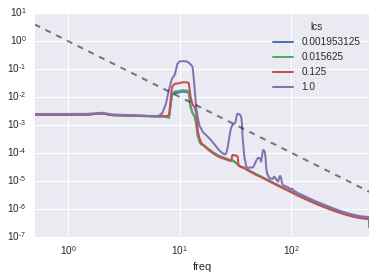

In [101]:
fig, ax = plt.subplots()

df = df_newctx_mts_lcs_cat.mean(axis=1).unstack('freq').T

df.plot(logx=True,logy=True,linewidth=2,ax=ax,legend=doleg)
    
linedat = 1/(df.index.values**2)
ax.plot(df.index,linedat, '--', c='k', linewidth=2,alpha=0.5)


In [86]:
newmat_hom = np.array([[0,0],[0,0]])
newconn_hom = connectivity.Connectivity()
newconn_hom.weights = newmat_hom
newconn_hom.region_labels = origconn.region_labels[rA1lA1_nodenums]
newconn_hom.centres = origconn.centres[rA1lA1_nodenums]
newconn_hom.cortical = origconn.cortical[rA1lA1_nodenums]
newconn_hom.hemispheres = origconn.hemispheres[rA1lA1_nodenums]
newconn_hom.tract_lengths = origconn.tract_lengths[rA1lA1_nodenums,:][:,rA1lA1_nodenums]
newconn_hom.configure()


In [87]:
df_newctx_hom_tavg_lcs = {lc: run_tvb_sim(params,sim_type='surface',local_coupling_strength=lc,
                                     surf=newctx,conn=newconn_hom)
                     for lc in lcs}

In [88]:
# Compute power spectra
# ---------------------

sampling_interval= np.unique(np.diff(df_newctx_hom_tavg_lcs.values()[0].index.values))[0] / 1000.

df_fs_lcs,df_mts_lcs = {},{}

for kv_it,(k,v) in enumerate(df_tavg_lcs.items()):

  df_fs,df_mts,S = compute_nitime_ps(v[all_idx1to5s].values.T,
                                     v.index[:,np.newaxis],
                                     sampling_interval)
  df_fs.columns = all_idx1to5s  
  df_mts.columns = all_idx1to5s    
    
  df_fs_lcs[k] = df_fs
  df_mts_lcs[k] = df_mts
    
# Concatenate into a singel pandas dataframe

df_newctx_hom_mts_lcs_cat = pd.concat(df_mts_lcs)
df_newctx_hom_mts_lcs_cat.index.names = ['lcs', 'freq']
df_newctx_hom_mts_lcs_cat.columns.names = ['vtx_num']

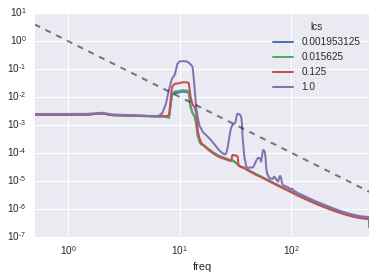

In [100]:
fig, ax = plt.subplots()

df = df_newctx_hom_mts_lcs_cat.mean(axis=1).unstack('freq').T

df.plot(logx=True,logy=True,linewidth=2,ax=ax,legend=doleg)
    
linedat = 1/(df.index.values**2)
ax.plot(df.index,linedat, '--', c='k', linewidth=2,alpha=0.5)


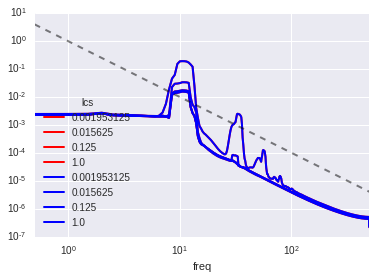

In [102]:
fig, ax = plt.subplots()

df = df_newctx_hom_mts_lcs_cat.mean(axis=1).unstack('freq').T
df.plot(logx=True,logy=True,linewidth=2,ax=ax,legend=doleg,c='r')

df = df_newctx_mts_lcs_cat.mean(axis=1).unstack('freq').T
df.plot(logx=True,logy=True,linewidth=2,ax=ax,legend=doleg,c='b')

linedat = 1/(df.index.values**2)
ax.plot(df.index,linedat, '--', c='k', linewidth=2,alpha=0.5)


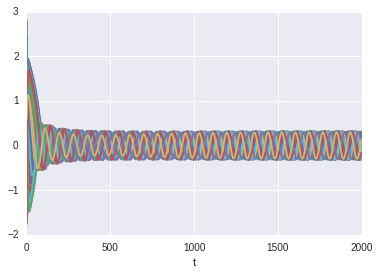

In [106]:
df_newctx_hom_tavg_lcs[lcs[0]].plot(legend=False)